# Transfer Learning by Fine Tuning
Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed 
set_random_seed(7)
from math import ceil
import efficientnet.keras as efn
from efficientnet.keras import center_crop_and_resize #, preprocess_input

import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils, to_categorical, plot_model
from keras.applications import imagenet_utils, resnet50, resnet
from keras.applications import resnext
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
#from kerastuner.tuners import RandomSearch

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Average, Concatenate
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.backend import clear_session
#free GPU memory
clear_session()

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

In [2]:
import tensorflow  as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6451991058774898055, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13707450545668847933
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7651406644
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13327232706148483247
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2377252151103678280
 physical_device_desc: "device: XLA_GPU device"]

## Introduction

This notebook contains the code for image classification using Transfer Learning by Fine Tuning with the ResNet50 and EfficientNetB4 built-in models. 

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed. Each model's own preprocessing is used. 

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

Data Augmentation is also done to increase the generalisability of the model.

In [4]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

(224, 224, 6, 1440)


In [5]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [6]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


In [7]:
#Scale the disp, ph and coh bands to 0 to 255
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))
X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

max, min 3.1391279697418213 -3.1403708457946777
band input shape (1440, 3, 224, 224)
scale band data shape (224, 224, 3, 1440)
scale band data reshaped (1440, 150528)
band output shape (1440, 3, 224, 224)
max, min 255.00000000000006 0.0


In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.00000000000006 0.0


In [9]:
#Reshape to Keras desired shape
X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

(1440, 224, 224, 6)


## Classification

The classifiers are implemented below using Transfer Learning by Fine Tuning with the ResNet50 and EfficientB4 models.

In [10]:
#Below code for multiple generator adapted from: https://github.com/keras-team/keras/issues/8130 
def multi_gen(generator, X, Y, batch_size, img_height,img_width):    
    gen_X0 = generator.flow(X[0], Y, batch_size = batch_size, shuffle=False, seed=7)    
    gen_X1 = generator.flow(X[1], batch_size = batch_size, shuffle=False, seed=7)
    
    while True:
            X0 = gen_X0.next()
            X1 = gen_X1.next()
            #Yield the 2 x 3 channel inputs and their mutual label
            #Had to rename input_2 to input_2_2 when renaming all layers in resnet_2
            yield ({'input_1': X0[0], 'input_2_2': X1[0]}, {'output': X0[1]})

#Below timing code adapted from: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
import time
class TimeHist(Callback):
    def at_train_start(self, logs={}):
        self.times = []

    def at_epoch_start(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def at_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
#Setup single models
def singleModel(img_res, model_str, X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test, y_train, y_val, 
                y_test, train_index, val_index, single_model_name_str, results_arr, dropout, counter):
    
    #For fine tuning set to 'imagenet'
    weights_str = 'imagenet'
        
    img_h = img_res
    img_w = img_res
    batch_Size = 32
    
    print(single_model_name_str)
    X_band_train = X_band_train_val[train_index].copy()
    X_band_val = X_band_train_val[val_index].copy()
    X_band_test = X_band_test.copy()
    X_rgb_train = X_rgb_train_val[train_index].copy()
    X_rgb_val = X_rgb_train_val[val_index].copy()
    X_rgb_test = X_rgb_test.copy()
    print('Band: Train: ', X_band_train.shape, 'Validation:', X_band_val.shape, 'Test:', X_band_test.shape)         
    print('RGB: Train: ', X_rgb_train.shape, 'Validation:', X_rgb_val.shape, 'Test:', X_rgb_test.shape)         
    del X_band_train_val, X_rgb_train_val
    
    if model_str == 'ResNet50':
        print("\n ResNet model \n")
        net_1 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 171 #168 
    elif model_str == 'EffNetB4':
        print("\n EfficientNet model \n")
        net_1 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 464 #460

    print(model_str + ' 1 input shape:', net_1.input.shape)
    print(model_str + ' 1 output shape:', net_1.output.shape)

    training_size = X_band_train.shape[0]
    validating_size = X_band_val.shape[0]
    testing_size = X_band_test.shape[0]

    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    for layer in net_2.layers:
        layer.name = layer.name + str('_2')

    preds1 = net_1.output
    preds1 = GlobalAveragePooling2D()(preds1)
    preds1 = Dropout(dropout)(preds1)
    #preds1 = Dense(512, activation='relu',)(preds1)
    #preds1 = Dropout(dropout)(preds1)
    preds1 = Dense(2, activation='softmax', name='Softmax_1')(preds1)
    preds2 = net_2.output
    preds2 = GlobalAveragePooling2D()(preds2)
    preds2 = Dropout(dropout)(preds2)
    #preds2 = Dense(512, activation='relu',)(preds2)
    #preds2 = Dropout(dropout)(preds2)
    preds2 = Dense(2, activation='softmax', name='Softmax_2')(preds2)
    preds = Average()([preds1, preds2])

    cnn_model = Model(inputs = [net_1.input, net_2.input], outputs = preds, name='ensemble')

    #Freeze the resnet layers except the final layer
    for layer in net_1.layers:
        layer.trainable = False
    for layer in net_2.layers:
        layer.trainable = False

    #optim = Adam(lr=0.0001)
    #optim = 'Adam'
    #optim = SGD(lr=1e-3, momentum=0.9, decay=1e-3/25)
    optim = SGD(lr=1e-4, momentum=0.9)
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])
    time_callback = TimeHist()
    #chkpt_path = "/from_scratch/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    chkpt_path = './model/' + single_model_name_str + '_bestmodel.hdf5'
    checkpointer = ModelCheckpoint(filepath=chkpt_path, monitor = 'val_loss',
                                   mode='min', verbose=1, save_best_only=True)                

    input_imgen = ImageDataGenerator(shear_range = 0.30, zoom_range = 0.30, width_shift_range=0.3, 
                height_shift_range=0.3, rotation_range = 60, horizontal_flip = True, fill_mode='nearest')
    #input_imgen = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, rotation_range = 5., 
    #                                 horizontal_flip = True)
    val_imgen = ImageDataGenerator()
    test_imgen = ImageDataGenerator()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=0, mode='auto', 
                                 min_lr=0.000001)
    callbacks_list = [checkpointer, time_callback, reduceLR, es,]
    
    train_generator = input_imgen.flow([X_band_train.copy(), X_rgb_train.copy()], y_train.copy(), 
                    batch_size=batch_Size, shuffle=False)
    val_generator = val_imgen.flow([X_band_val.copy(), X_rgb_val.copy()], y_val.copy(), batch_size=batch_Size, shuffle=False)
    test_generator = test_imgen.flow([X_band_test.copy(), X_rgb_test.copy()], batch_size=batch_Size, shuffle=False)
    
    history = cnn_model.fit_generator(train_generator, steps_per_epoch=round(training_size/batch_Size), epochs = 50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    test_preds = cnn_model.predict_generator(test_generator, steps=round(testing_size/batch_Size))
    
    #Testing Accuracy before unfreezing the final conv block
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    
    print('\n', single_model_name_str + ' : Counter: %i, Testing Accuracy: %.2f %% \n' % (counter, test_acc))
    results_arr.append(test_acc)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    #Unfreeze the final conv block, its 171 and not 49 for ResNet50
    for layer in net_1.layers[last_conv_layer_no:]:
        layer.trainable = True
    for layer in net_2.layers[last_conv_layer_no:]:
        layer.trainable = True

    #Print trainable layers
    if counter == 0:
        count = 0
        for layer in net_1.layers:
            print(model_str + ' 1: {} {}: {}'.format(count, layer, layer.trainable))
            count = count + 1
        count = 0
        for layer in net_2.layers:
            print(model_str + ' 2: {} {}: {}'.format(count, layer, layer.trainable))
            count = count + 1

    print('\n \n ############################################### \n \n Retraining with last conv layer unfrozen \n ')
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])

    history = cnn_model.fit_generator(train_generator, steps_per_epoch = round(training_size/batch_Size), epochs =50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    #load the saved model
    saved_model = load_model(chkpt_path)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    train_preds = saved_model.predict_generator(train_generator, steps = round(training_size/batch_Size))
    val_preds = saved_model.predict_generator(val_generator, steps = ceil(validating_size/batch_Size))
    
    test_preds = saved_model.predict_generator(test_generator, steps = round(testing_size/batch_Size))
    print('validating_size', validating_size, 'val_preds', val_preds.shape, 'y_val: ', y_val.shape)
    
    #train_acc = round(accuracy_score(np.argmax(y_train.copy(), axis=1), np.argmax(train_preds.copy(), axis=1))*100, 2)
    val_acc = round(accuracy_score(np.argmax(y_val.copy(), axis=1), np.argmax(val_preds.copy(), axis=1))*100, 2)
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    print(single_model_name_str + ' : Counter: %i, Accuracies: Validation: %.2f %%, Test: %.2f %%' % (counter, 
            val_acc, test_acc))

    if counter == 0:
        plot_model(cnn_model, to_file= './model/' + single_model_name_str + '_Architecture.png')
        #cnn_model.summary()

    #Visualisation code from Keras API dcumentation: https://keras.io/visualization/
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_Accuracy_' + str(counter) + '.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_Loss_' + str(counter) + '.png')
    plt.show()

    del history, saved_model, cnn_model
    
    results_arr.append(val_acc)
    results_arr.append(test_acc)     
    results_arr = evaluator(np.round(np.argmax(test_preds.copy(),axis=1)), np.argmax(y_test.copy(), axis=1), results_arr)
    
    del X_band_train, X_rgb_train, X_band_val, X_rgb_val, y_train, y_val, y_test, X_band_test, X_rgb_test
    clear_session()
    del net_1, net_2, train_preds 
    return val_preds, test_preds, results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(val_preds, test_preds, y_val, y_test, ensemble_str, results_arr):
    val_preds = np.mean(val_preds, axis=0)
    test_preds = np.mean(test_preds, axis=0)
    ensemble_preds_val = np.argmax(val_preds, axis=1)
    ensemble_preds_test = np.argmax(test_preds, axis=1)
    ensemble_val_acc = np.round(accuracy_score(y_val, np.round(ensemble_preds_val))*100, 2)
    print('Validation score of ' + ensemble_str + ': ', ensemble_val_acc, '%')
    ensemble_test_acc = np.round(accuracy_score(y_test.copy(), np.round(ensemble_preds_test))*100, 2)
    print('Test score of ' + ensemble_str + ': ', ensemble_test_acc, '%')
    
    results_arr.append('N/A')    
    results_arr.append(ensemble_val_acc)
    results_arr.append(ensemble_test_acc)
    results_arr = evaluator(np.round(ensemble_preds_test.copy()), y_test.copy(), results_arr)
    return results_arr

In [12]:
#Function to train model 
def trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test, 
               y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test):
        
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    sss.get_n_splits(X_resnet50_band_train_val, y_train_val)

    dropout=[0.2, 0.3, 0.4]
    single_model_name = ['ResNet50 FT Dropout: ' + str(dropout[0]), 'ResNet50 FT Dropout: ' + str(dropout[1]), 
                         'ResNet50 FT Dropout: ' + str(dropout[2]), 'EfficientNet B4 FT Dropout: ' + str(dropout[0]),
                        'EfficientNet B4 FT Dropout: ' + str(dropout[1]), 'EfficientNet B4 FT Dropout: ' + str(dropout[2]),]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Test Acc B4 Unfreezing Last Conv Layer', 'Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    
    ensemble_names = ['Ensemble of 1 & 2',]
    for i in range(len(ensemble_names)):
        for j in range(len(subnames)):
            col_names.append(ensemble_names[i] + ' ' + subnames[j])
    
    results_data = pd.DataFrame(columns=col_names)
    results_arr = []
    
    counter = 0
    for train_index, val_index in sss.split(X_resnet50_band_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('Counter: ',counter)
        
        results_arr.append(counter)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
 
        # Model 1 ResNet50 Fine Tuning
        preds_1, test_preds_1, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, dropout[0], counter)
        
        preds_2, test_preds_2, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, dropout[1], counter)

        preds_3, test_preds_3, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[2], results_arr, dropout[2], counter)
        
        # Model 2 EfficientNet B4 Fine Tuning
        preds_4, test_preds_4, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[3], results_arr, dropout[0], counter)
                    
        preds_5, test_preds_5, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[4], results_arr, dropout[1], counter)
                    
        preds_6, test_preds_6, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[5], results_arr, dropout[2], counter)
        
        #Ensembling
        val_preds = np.stack((preds_1, preds_2))
        test_preds = np.stack((test_preds_1, test_preds_2))
        results_arr = ensembler(val_preds, test_preds, y_val.copy(), y_test.copy(), ensemble_names[0], results_arr)
           
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        counter = counter + 1
        del y_train, y_val, 
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    del X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test
    del X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test
    return results_data

X, y shapes:  (1440, 224, 224, 6) (1440,)
X_resnet50_band_train_val processed: max, min 151.061 -123.68
X_resnet50_rgb_train_val processed: max, min 151.061 -123.68
X_resnet50_band_test processed: max, min 151.061 -123.68
X_resnet50_rgb_test processed: max, min 151.061 -123.68
X_effnet_bands_train_val processed: max, min 2.64 -2.117904
X_effnet_rgb_train_val processed: max, min 2.64 -2.117904
X_effnet_bands_test processed: max, min 2.64 -2.117904
X_effnet_rgb_test processed: max, min 2.64 -2.117904
Model 1: ResNet50 FT Dropout: 0.2
Model 2: ResNet50 FT Dropout: 0.3
Model 3: ResNet50 FT Dropout: 0.4
Model 4: EfficientNet B4 FT Dropout: 0.2
Model 5: EfficientNet B4 FT Dropout: 0.3
Model 6: EfficientNet B4 FT Dropout: 0.4
Overlap set()
Counter:  0
ResNet50 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 





ResNet50 1 input shape

Epoch 1/50
29/29 [==============================] - 13s 438ms/step - loss: 0.3554 - acc: 0.8436 - val_loss: 0.4609 - val_acc: 0.8312

Epoch 00001: val_loss improved from 0.46321 to 0.46095, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 297ms/step - loss: 0.3583 - acc: 0.8466 - val_loss: 0.4582 - val_acc: 0.8312

Epoch 00002: val_loss improved from 0.46095 to 0.45820, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 9s 297ms/step - loss: 0.3525 - acc: 0.8447 - val_loss: 0.4565 - val_acc: 0.8355

Epoch 00003: val_loss improved from 0.45820 to 0.45651, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 9s 298ms/step - loss: 0.3501 - acc: 0.8598 - val_loss: 0.4540 - val_acc: 0.8355

Epoch 00004: val_loss improved from 0.45651 to 0.45401, saving model to ./model/ResNet50 FT Dropout: 0.2_be

Epoch 36/50
29/29 [==============================] - 9s 298ms/step - loss: 0.3003 - acc: 0.8792 - val_loss: 0.4228 - val_acc: 0.8442

Epoch 00036: val_loss improved from 0.42408 to 0.42285, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 37/50
29/29 [==============================] - 9s 296ms/step - loss: 0.2953 - acc: 0.8781 - val_loss: 0.4227 - val_acc: 0.8442

Epoch 00037: val_loss improved from 0.42285 to 0.42272, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 38/50
29/29 [==============================] - 9s 297ms/step - loss: 0.2897 - acc: 0.8821 - val_loss: 0.4227 - val_acc: 0.8442

Epoch 00038: val_loss improved from 0.42272 to 0.42270, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 39/50
29/29 [==============================] - 9s 297ms/step - loss: 0.2930 - acc: 0.8949 - val_loss: 0.4212 - val_acc: 0.8442

Epoch 00039: val_loss improved from 0.42270 to 0.42115, saving model to ./model/ResNet50 FT Dropout: 0.2

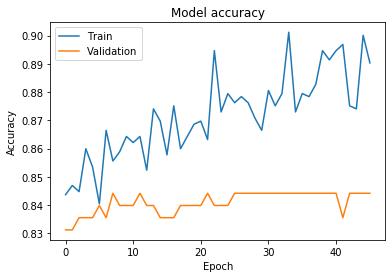

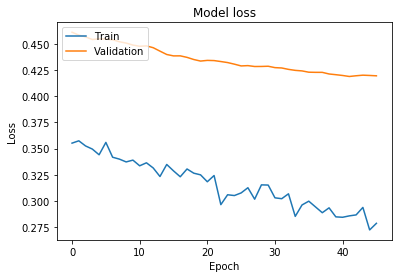

F1 score is:  0.78
Recall score is:  0.78
Precision score is:  0.78
Confusion matrix: 
 [[106  38]
 [ 26 118]]
From the confusion matrix above there are 106 true negatives and 38 false positives.
There are 26 false negatives and 118 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 419ms/step - loss: 0.8265 - acc: 0.5384 - val_loss: 0.8463 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 0.84629, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 290ms/step - loss: 0.7131 - acc: 0.5598 - val_loss: 0.9113 - val_acc: 0.5108

Epoch 00002: val_loss did not improve from 0.84629
Epoch 3/50
29/

Epoch 1/50
29/29 [==============================] - 13s 464ms/step - loss: 0.6488 - acc: 0.6239 - val_loss: 0.8223 - val_acc: 0.5152

Epoch 00001: val_loss improved from 0.84629 to 0.82227, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 296ms/step - loss: 0.6259 - acc: 0.6277 - val_loss: 0.8166 - val_acc: 0.5152

Epoch 00002: val_loss improved from 0.82227 to 0.81663, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 9s 296ms/step - loss: 0.6316 - acc: 0.6767 - val_loss: 0.8132 - val_acc: 0.5152

Epoch 00003: val_loss improved from 0.81663 to 0.81322, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 9s 296ms/step - loss: 0.6234 - acc: 0.6603 - val_loss: 0.8127 - val_acc: 0.5152

Epoch 00004: val_loss improved from 0.81322 to 0.81265, saving model to ./model/ResNet50 FT Dropout: 0.3_be

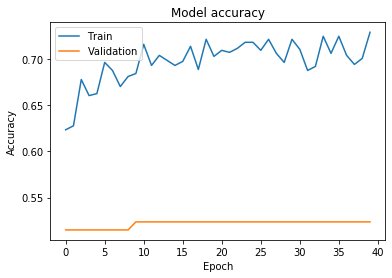

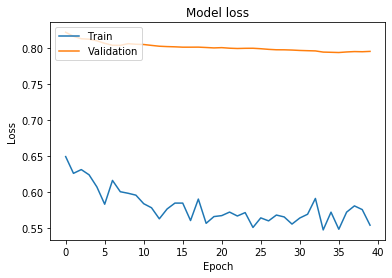

F1 score is:  0.36
Recall score is:  0.75
Precision score is:  0.51
Confusion matrix: 
 [[144   0]
 [140   4]]
From the confusion matrix above there are 144 true negatives and 0 false positives.
There are 140 false negatives and 4 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 416ms/step - loss: 0.7176 - acc: 0.5616 - val_loss: 0.7493 - val_acc: 0.5152

Epoch 00001: val_loss improved from inf to 0.74931, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.6839 - acc: 0.5937 - val_loss: 0.7162 - val_acc: 0.5584

Epoch 00002: val_loss improved from 0.74931 to 0.71624, saving mode

Epoch 1/50
29/29 [==============================] - 13s 445ms/step - loss: 0.4358 - acc: 0.7964 - val_loss: 0.4917 - val_acc: 0.7489

Epoch 00001: val_loss improved from 0.49187 to 0.49166, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4398 - acc: 0.8024 - val_loss: 0.4918 - val_acc: 0.7489

Epoch 00002: val_loss did not improve from 0.49166
Epoch 3/50
29/29 [==============================] - 9s 298ms/step - loss: 0.4301 - acc: 0.8175 - val_loss: 0.4914 - val_acc: 0.7489

Epoch 00003: val_loss improved from 0.49166 to 0.49143, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4366 - acc: 0.8042 - val_loss: 0.4923 - val_acc: 0.7489

Epoch 00004: val_loss did not improve from 0.49143
Epoch 5/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4391 - acc: 0.7994 - val_loss: 0.4921 - val_acc: 

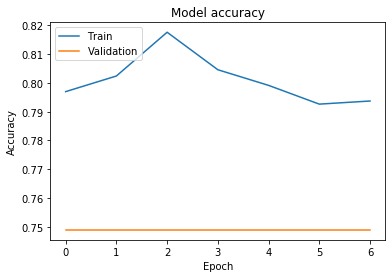

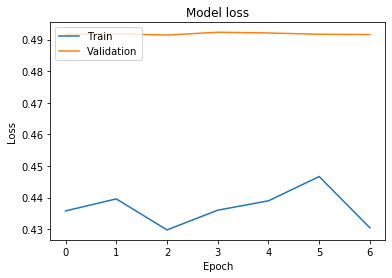

F1 score is:  0.76
Recall score is:  0.77
Precision score is:  0.76
Confusion matrix: 
 [[123  21]
 [ 47  97]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 47 false negatives and 97 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 904ms/step - loss: 0.7137 - acc: 0.4827 - val_loss: 0.7443 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.74434, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 541ms/step - loss: 0.7108 - acc: 0.4885 - val_loss: 0.7413 - val_acc: 0.4978

Epoch 00002: val_loss improved from 0.74434 t

Epoch 1/50
29/29 [==============================] - 26s 880ms/step - loss: 0.5976 - acc: 0.7175 - val_loss: 0.6221 - val_acc: 0.6537

Epoch 00001: val_loss improved from 0.63112 to 0.62213, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5858 - acc: 0.7385 - val_loss: 0.6203 - val_acc: 0.6537

Epoch 00002: val_loss improved from 0.62213 to 0.62027, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5857 - acc: 0.7231 - val_loss: 0.6180 - val_acc: 0.6667

Epoch 00003: val_loss improved from 0.62027 to 0.61797, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5843 - acc: 0.7414 - val_loss: 0.6165 - val_acc: 0.6840

Epoch 00004: val_loss improved from 0.61797 to 0.61647, saving model to ./model/Eff

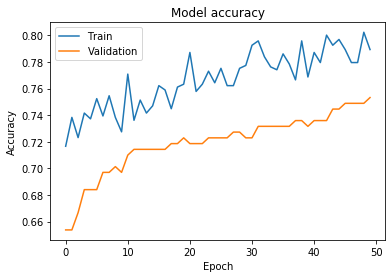

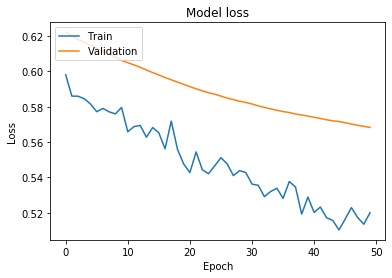

F1 score is:  0.7
Recall score is:  0.7
Precision score is:  0.7
Confusion matrix: 
 [[ 96  48]
 [ 39 105]]
From the confusion matrix above there are 96 true negatives and 48 false positives.
There are 39 false negatives and 105 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 854ms/step - loss: 0.7217 - acc: 0.4896 - val_loss: 0.7212 - val_acc: 0.4069

Epoch 00001: val_loss improved from inf to 0.72117, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7227 - acc: 0.4667 - val_loss: 0.7191 - val_acc: 0.4156

Epoch 00002: val_loss improved from 0.72117 to 0

Epoch 1/50
29/29 [==============================] - 26s 881ms/step - loss: 0.6014 - acc: 0.7040 - val_loss: 0.6530 - val_acc: 0.5931

Epoch 00001: val_loss improved from 0.65619 to 0.65295, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5935 - acc: 0.7188 - val_loss: 0.6527 - val_acc: 0.5844

Epoch 00002: val_loss improved from 0.65295 to 0.65272, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5854 - acc: 0.7253 - val_loss: 0.6514 - val_acc: 0.5931

Epoch 00003: val_loss improved from 0.65272 to 0.65139, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5810 - acc: 0.7326 - val_loss: 0.6502 - val_acc: 0.5974

Epoch 00004: val_loss improved from 0.65139 to 0.65020, saving model to ./model/Eff

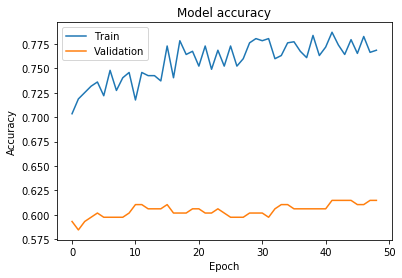

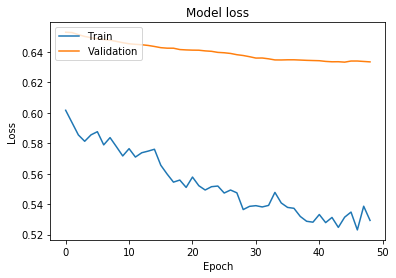

F1 score is:  0.62
Recall score is:  0.69
Precision score is:  0.65
Confusion matrix: 
 [[129  15]
 [ 87  57]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 87 false negatives and 57 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 859ms/step - loss: 0.7195 - acc: 0.4683 - val_loss: 0.6939 - val_acc: 0.5152

Epoch 00001: val_loss improved from inf to 0.69386, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7158 - acc: 0.4972 - val_loss: 0.6921 - val_acc: 0.5065

Epoch 00002: val_loss improved from 0.69386 t

Epoch 1/50
29/29 [==============================] - 25s 878ms/step - loss: 0.5960 - acc: 0.7064 - val_loss: 0.6471 - val_acc: 0.5628

Epoch 00001: val_loss improved from 0.64873 to 0.64711, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5976 - acc: 0.7080 - val_loss: 0.6468 - val_acc: 0.5628

Epoch 00002: val_loss improved from 0.64711 to 0.64680, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 16s 549ms/step - loss: 0.6042 - acc: 0.7041 - val_loss: 0.6463 - val_acc: 0.5628

Epoch 00003: val_loss improved from 0.64680 to 0.64635, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5939 - acc: 0.7112 - val_loss: 0.6466 - val_acc: 0.5584

Epoch 00004: val_loss did not improve from 0.64635
Epoch 5/50
29/29 [==============

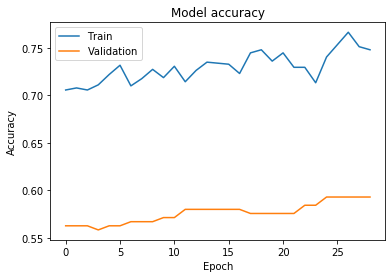

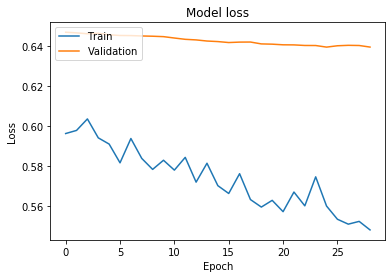

F1 score is:  0.56
Recall score is:  0.74
Precision score is:  0.62
Confusion matrix: 
 [[140   4]
 [106  38]]
From the confusion matrix above there are 140 true negatives and 4 false positives.
There are 106 false negatives and 38 true positives. 

Validation score of Ensemble of 1 & 2:  70.13 %
Test score of Ensemble of 1 & 2:  65.97 %
F1 score is:  0.63
Recall score is:  0.72
Precision score is:  0.66
Confusion matrix: 
 [[133  11]
 [ 87  57]]
From the confusion matrix above there are 133 true negatives and 11 false positives.
There are 87 false negatives and 57 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 

   ResNet50 FT Dropout: 0.2 Val Acc  ResNet50 FT Dropout: 0.2 Test Acc  \
0                             83.55                              77.78   

   ResNet50 FT Dropout: 0.2 F1 score  ResNet50 FT Dropout: 0.2 Precision  \
0           

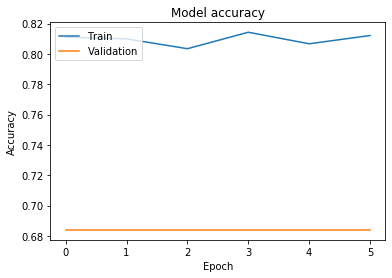

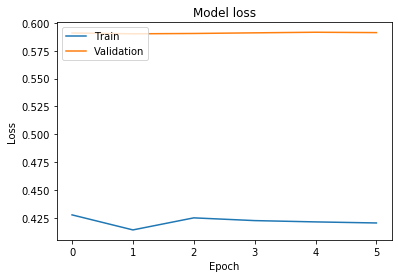

F1 score is:  0.66
Recall score is:  0.75
Precision score is:  0.68
Confusion matrix: 
 [[136   8]
 [ 84  60]]
From the confusion matrix above there are 136 true negatives and 8 false positives.
There are 84 false negatives and 60 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 415ms/step - loss: 0.9207 - acc: 0.3893 - val_loss: 0.8283 - val_acc: 0.4502

Epoch 00001: val_loss improved from inf to 0.82826, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 288ms/step - loss: 0.8368 - acc: 0.4410 - val_loss: 0.7770 - val_acc: 0.4805

Epoch 00002: val_loss improved from 0.82826 to 0.77700, saving mode

Epoch 32/50
29/29 [==============================] - 8s 290ms/step - loss: 0.4457 - acc: 0.7986 - val_loss: 0.5476 - val_acc: 0.6753

Epoch 00032: val_loss improved from 0.55370 to 0.54760, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 290ms/step - loss: 0.4499 - acc: 0.7945 - val_loss: 0.5497 - val_acc: 0.6753

Epoch 00033: val_loss did not improve from 0.54760
Epoch 34/50
29/29 [==============================] - 8s 292ms/step - loss: 0.4549 - acc: 0.7927 - val_loss: 0.5415 - val_acc: 0.6797

Epoch 00034: val_loss improved from 0.54760 to 0.54146, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4479 - acc: 0.8124 - val_loss: 0.5443 - val_acc: 0.6840

Epoch 00035: val_loss did not improve from 0.54146
Epoch 36/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4306 - acc: 0.8127 - val_loss: 0.5439 - val_a

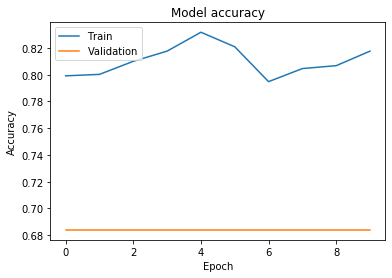

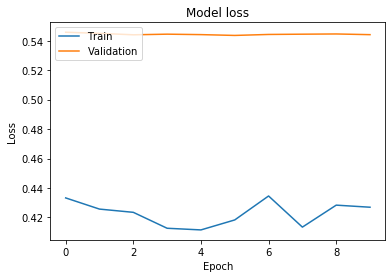

F1 score is:  0.71
Recall score is:  0.73
Precision score is:  0.72
Confusion matrix: 
 [[120  24]
 [ 58  86]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 58 false negatives and 86 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 412ms/step - loss: 0.8073 - acc: 0.5087 - val_loss: 0.9401 - val_acc: 0.5065

Epoch 00001: val_loss improved from inf to 0.94011, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.7402 - acc: 0.5576 - val_loss: 0.8773 - val_acc: 0.5152

Epoch 00002: val_loss improved from 0.94011 to 0.87732, saving mod

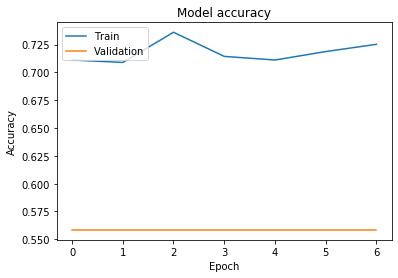

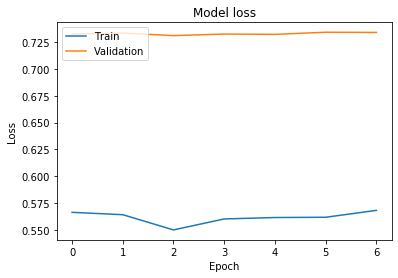

F1 score is:  0.42
Recall score is:  0.67
Precision score is:  0.53
Confusion matrix: 
 [[141   3]
 [131  13]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 131 false negatives and 13 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 853ms/step - loss: 0.7349 - acc: 0.4666 - val_loss: 0.7190 - val_acc: 0.4199

Epoch 00001: val_loss improved from inf to 0.71896, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7241 - acc: 0.4640 - val_loss: 0.7169 - val_acc: 0.4329

Epoch 00002: val_loss improved from 0.71896 t

Epoch 11/50
29/29 [==============================] - 16s 546ms/step - loss: 0.5804 - acc: 0.7321 - val_loss: 0.6509 - val_acc: 0.5541

Epoch 00011: val_loss improved from 0.65139 to 0.65087, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5791 - acc: 0.7406 - val_loss: 0.6501 - val_acc: 0.5541

Epoch 00012: val_loss improved from 0.65087 to 0.65007, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5764 - acc: 0.7584 - val_loss: 0.6498 - val_acc: 0.5584

Epoch 00013: val_loss improved from 0.65007 to 0.64981, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5903 - acc: 0.7306 - val_loss: 0.6489 - val_acc: 0.5628

Epoch 00014: val_loss improved from 0.64981 to 0.64893, saving model to ./model

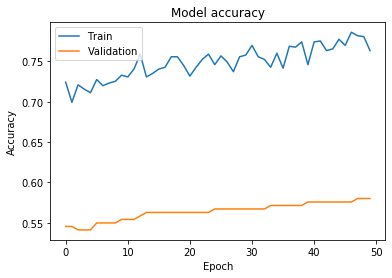

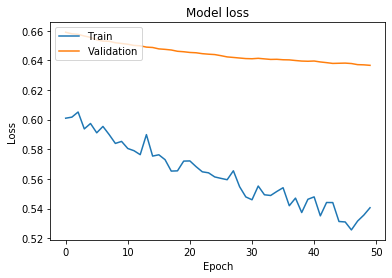

F1 score is:  0.63
Recall score is:  0.73
Precision score is:  0.66
Confusion matrix: 
 [[135   9]
 [ 89  55]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 89 false negatives and 55 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 858ms/step - loss: 0.7017 - acc: 0.5263 - val_loss: 0.7244 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.72436, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.6938 - acc: 0.5350 - val_loss: 0.7215 - val_acc: 0.5065

Epoch 00002: val_loss improved from 0.72436 to

Epoch 11/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5828 - acc: 0.7222 - val_loss: 0.6027 - val_acc: 0.6970

Epoch 00011: val_loss improved from 0.60414 to 0.60270, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5715 - acc: 0.7306 - val_loss: 0.6013 - val_acc: 0.6970

Epoch 00012: val_loss improved from 0.60270 to 0.60128, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5734 - acc: 0.7212 - val_loss: 0.6000 - val_acc: 0.6970

Epoch 00013: val_loss improved from 0.60128 to 0.60004, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5839 - acc: 0.7223 - val_loss: 0.5989 - val_acc: 0.6970

Epoch 00014: val_loss improved from 0.60004 to 0.59886, saving model to ./model

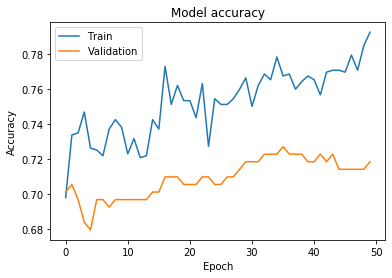

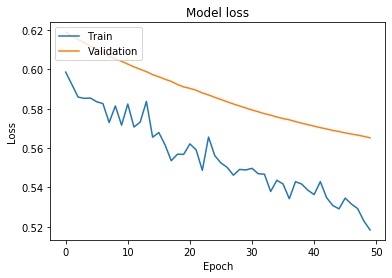

F1 score is:  0.68
Recall score is:  0.69
Precision score is:  0.68
Confusion matrix: 
 [[ 91  53]
 [ 38 106]]
From the confusion matrix above there are 91 true negatives and 53 false positives.
There are 38 false negatives and 106 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 857ms/step - loss: 0.6924 - acc: 0.5496 - val_loss: 0.6849 - val_acc: 0.5541

Epoch 00001: val_loss improved from inf to 0.68490, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 539ms/step - loss: 0.6799 - acc: 0.5637 - val_loss: 0.6830 - val_acc: 0.5714

Epoch 00002: val_loss improved from 0.68490 t

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5728 - acc: 0.7277 - val_loss: 0.6156 - val_acc: 0.6537

Epoch 00011: val_loss improved from 0.61589 to 0.61555, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5888 - acc: 0.6899 - val_loss: 0.6145 - val_acc: 0.6537

Epoch 00012: val_loss improved from 0.61555 to 0.61452, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5714 - acc: 0.7406 - val_loss: 0.6139 - val_acc: 0.6537

Epoch 00013: val_loss improved from 0.61452 to 0.61393, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5739 - acc: 0.7204 - val_loss: 0.6136 - val_acc: 0.6537

Epoch 00014: val_loss improved from 0.61393 to 0.61362, saving model to ./model

Epoch 43/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5390 - acc: 0.7587 - val_loss: 0.6031 - val_acc: 0.6494

Epoch 00043: val_loss did not improve from 0.60276
Epoch 44/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5317 - acc: 0.7794 - val_loss: 0.6033 - val_acc: 0.6450

Epoch 00044: val_loss did not improve from 0.60276
Epoch 45/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5414 - acc: 0.7398 - val_loss: 0.6027 - val_acc: 0.6494

Epoch 00045: val_loss improved from 0.60276 to 0.60270, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 46/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5375 - acc: 0.7684 - val_loss: 0.6027 - val_acc: 0.6494

Epoch 00046: val_loss did not improve from 0.60270
Epoch 47/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5221 - acc: 0.7776 - val_loss: 0.6026 - val_acc: 0.6494

Epoch 00047: val_loss improved from 0.60270 t

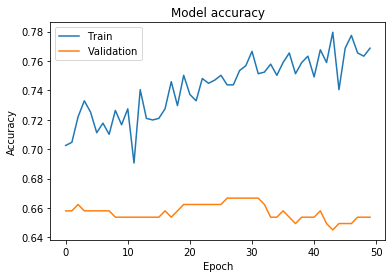

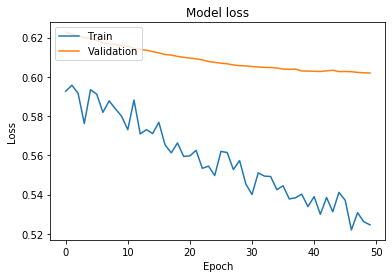

F1 score is:  0.65
Recall score is:  0.72
Precision score is:  0.67
Confusion matrix: 
 [[130  14]
 [ 81  63]]
From the confusion matrix above there are 130 true negatives and 14 false positives.
There are 81 false negatives and 63 true positives. 

Validation score of Ensemble of 1 & 2:  70.56 %
Test score of Ensemble of 1 & 2:  70.83 %
F1 score is:  0.69
Recall score is:  0.76
Precision score is:  0.71
Confusion matrix: 
 [[134  10]
 [ 74  70]]
From the confusion matrix above there are 134 true negatives and 10 false positives.
There are 74 false negatives and 70 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 

   ResNet50 FT Dropout: 0.2 Val Acc  ResNet50 FT Dropout: 0.2 Test Acc  \
0                             83.55                              77.78   
1          


Epoch 00021: val_loss did not improve from 0.58270
Epoch 22/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4678 - acc: 0.7948 - val_loss: 0.5804 - val_acc: 0.6667

Epoch 00022: val_loss improved from 0.58270 to 0.58040, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 23/50
29/29 [==============================] - 8s 290ms/step - loss: 0.4567 - acc: 0.7905 - val_loss: 0.5800 - val_acc: 0.6753

Epoch 00023: val_loss improved from 0.58040 to 0.57999, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 24/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4494 - acc: 0.8030 - val_loss: 0.5780 - val_acc: 0.6797

Epoch 00024: val_loss improved from 0.57999 to 0.57801, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 25/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4589 - acc: 0.7930 - val_loss: 0.5771 - val_acc: 0.6797

Epoch 00025: val_loss improved from 0.57801 to 0.577

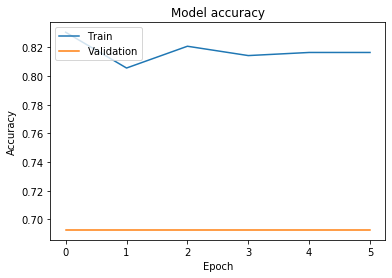

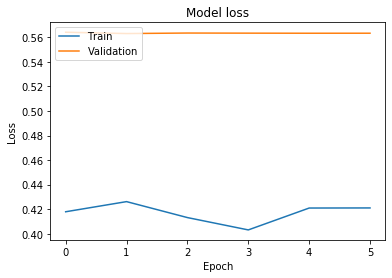

F1 score is:  0.7
Recall score is:  0.72
Precision score is:  0.7
Confusion matrix: 
 [[121  23]
 [ 63  81]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 63 false negatives and 81 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 421ms/step - loss: 0.8552 - acc: 0.4392 - val_loss: 1.0379 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 1.03794, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 290ms/step - loss: 0.7959 - acc: 0.4934 - val_loss: 0.9498 - val_acc: 0.5022

Epoch 00002: val_loss improved from 1.03794 to 0.94978, saving model

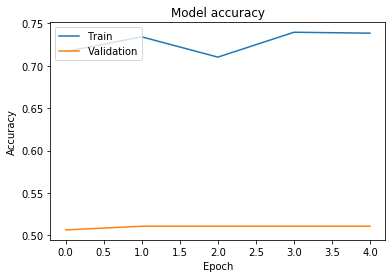

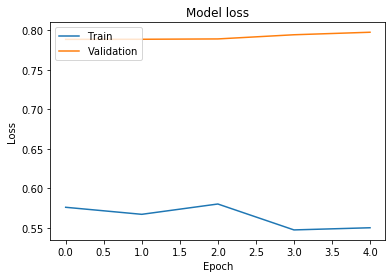

F1 score is:  0.35
Recall score is:  0.58
Precision score is:  0.5
Confusion matrix: 
 [[143   1]
 [142   2]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 142 false negatives and 2 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 423ms/step - loss: 0.8293 - acc: 0.4791 - val_loss: 0.8357 - val_acc: 0.4502

Epoch 00001: val_loss improved from inf to 0.83568, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.7848 - acc: 0.5185 - val_loss: 0.8045 - val_acc: 0.4719

Epoch 00002: val_loss improved from 0.83568 to 0.80448, saving model

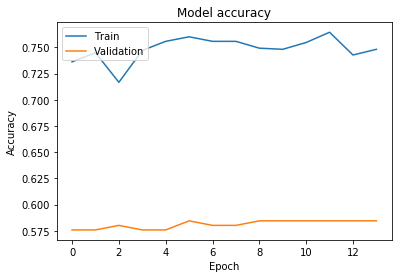

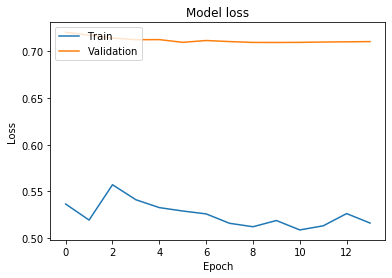

F1 score is:  0.6
Recall score is:  0.66
Precision score is:  0.62
Confusion matrix: 
 [[123  21]
 [ 88  56]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 88 false negatives and 56 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 871ms/step - loss: 0.6960 - acc: 0.5387 - val_loss: 0.6788 - val_acc: 0.5801

Epoch 00001: val_loss improved from inf to 0.67876, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 543ms/step - loss: 0.7052 - acc: 0.5249 - val_loss: 0.6772 - val_acc: 0.5887

Epoch 00002: val_loss improved from 0.67876 to

Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5687 - acc: 0.7371 - val_loss: 0.6258 - val_acc: 0.6407

Epoch 00012: val_loss improved from 0.62631 to 0.62578, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5643 - acc: 0.7452 - val_loss: 0.6254 - val_acc: 0.6407

Epoch 00013: val_loss improved from 0.62578 to 0.62539, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5613 - acc: 0.7431 - val_loss: 0.6250 - val_acc: 0.6407

Epoch 00014: val_loss improved from 0.62539 to 0.62503, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5727 - acc: 0.7233 - val_loss: 0.6249 - val_acc: 0.6364

Epoch 00015: val_loss improved from 0.62503 to 0.62488, saving model to ./model

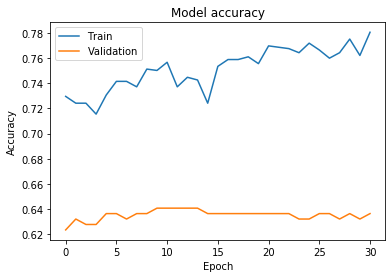

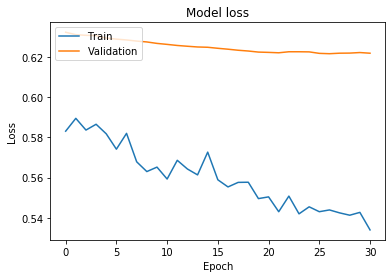

F1 score is:  0.6
Recall score is:  0.65
Precision score is:  0.62
Confusion matrix: 
 [[120  24]
 [ 85  59]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 85 false negatives and 59 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 854ms/step - loss: 0.6995 - acc: 0.5266 - val_loss: 0.6837 - val_acc: 0.5281

Epoch 00001: val_loss improved from inf to 0.68372, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 539ms/step - loss: 0.7019 - acc: 0.5130 - val_loss: 0.6821 - val_acc: 0.5281

Epoch 00002: val_loss improved from 0.68372 to

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5680 - acc: 0.7377 - val_loss: 0.6205 - val_acc: 0.6494

Epoch 00011: val_loss improved from 0.62123 to 0.62055, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5625 - acc: 0.7476 - val_loss: 0.6198 - val_acc: 0.6494

Epoch 00012: val_loss improved from 0.62055 to 0.61981, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5671 - acc: 0.7423 - val_loss: 0.6198 - val_acc: 0.6494

Epoch 00013: val_loss did not improve from 0.61981
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5637 - acc: 0.7485 - val_loss: 0.6189 - val_acc: 0.6450

Epoch 00014: val_loss improved from 0.61981 to 0.61893, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 15/50
29/29 [=========

29/29 [==============================] - 16s 552ms/step - loss: 0.5247 - acc: 0.7784 - val_loss: 0.6104 - val_acc: 0.6537

Epoch 00044: val_loss did not improve from 0.60974
Epoch 45/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5213 - acc: 0.7833 - val_loss: 0.6102 - val_acc: 0.6537

Epoch 00045: val_loss did not improve from 0.60974
Epoch 46/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5253 - acc: 0.7739 - val_loss: 0.6105 - val_acc: 0.6537

Epoch 00046: val_loss did not improve from 0.60974
Epoch 00046: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
EfficientNet B4 FT Dropout: 0.3 : Counter: 2, Accuracies: Validation: 64.94 %, Test: 65.62 %


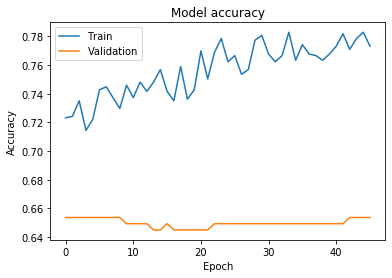

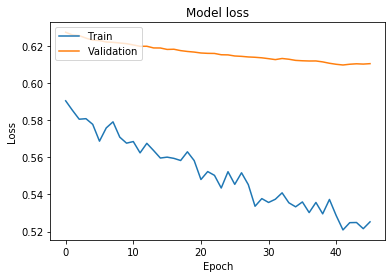

F1 score is:  0.64
Recall score is:  0.69
Precision score is:  0.66
Confusion matrix: 
 [[126  18]
 [ 81  63]]
From the confusion matrix above there are 126 true negatives and 18 false positives.
There are 81 false negatives and 63 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 864ms/step - loss: 0.7262 - acc: 0.4750 - val_loss: 0.7065 - val_acc: 0.4935

Epoch 00001: val_loss improved from inf to 0.70654, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.7246 - acc: 0.4858 - val_loss: 0.7044 - val_acc: 0.4978

Epoch 00002: val_loss improved from 0.70654 t

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5804 - acc: 0.7281 - val_loss: 0.6215 - val_acc: 0.6840

Epoch 00011: val_loss improved from 0.62252 to 0.62153, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5768 - acc: 0.7306 - val_loss: 0.6207 - val_acc: 0.6883

Epoch 00012: val_loss improved from 0.62153 to 0.62068, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 562ms/step - loss: 0.5772 - acc: 0.7250 - val_loss: 0.6199 - val_acc: 0.6840

Epoch 00013: val_loss improved from 0.62068 to 0.61992, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5799 - acc: 0.7377 - val_loss: 0.6190 - val_acc: 0.6840

Epoch 00014: val_loss improved from 0.61992 to 0.61897, saving model to ./model

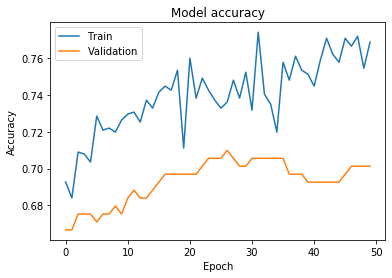

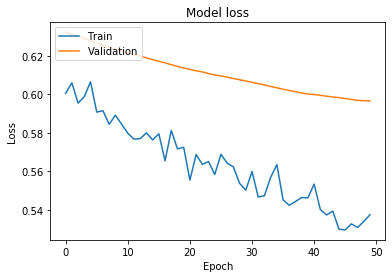

F1 score is:  0.67
Recall score is:  0.67
Precision score is:  0.67
Confusion matrix: 
 [[101  43]
 [ 53  91]]
From the confusion matrix above there are 101 true negatives and 43 false positives.
There are 53 false negatives and 91 true positives. 

Validation score of Ensemble of 1 & 2:  62.77 %
Test score of Ensemble of 1 & 2:  64.24 %
F1 score is:  0.61
Recall score is:  0.72
Precision score is:  0.64
Confusion matrix: 
 [[136   8]
 [ 95  49]]
From the confusion matrix above there are 136 true negatives and 8 false positives.
There are 95 false negatives and 49 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 

   ResNet50 FT Dropout: 0.2 Val Acc  ResNet50 FT Dropout: 0.2 Test Acc  \
0       

29/29 [==============================] - 8s 290ms/step - loss: 0.4982 - acc: 0.7759 - val_loss: 0.5752 - val_acc: 0.7273

Epoch 00018: val_loss improved from 0.58025 to 0.57522, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 19/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4780 - acc: 0.7797 - val_loss: 0.5700 - val_acc: 0.7273

Epoch 00019: val_loss improved from 0.57522 to 0.57001, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 20/50
29/29 [==============================] - 8s 290ms/step - loss: 0.4960 - acc: 0.7587 - val_loss: 0.5649 - val_acc: 0.7359

Epoch 00020: val_loss improved from 0.57001 to 0.56486, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 21/50
29/29 [==============================] - 8s 290ms/step - loss: 0.4694 - acc: 0.7827 - val_loss: 0.5606 - val_acc: 0.7359

Epoch 00021: val_loss improved from 0.56486 to 0.56058, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.h

29/29 [==============================] - 9s 298ms/step - loss: 0.3186 - acc: 0.8619 - val_loss: 0.4553 - val_acc: 0.7749

Epoch 00033: val_loss improved from 0.45650 to 0.45533, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 9s 298ms/step - loss: 0.3183 - acc: 0.8679 - val_loss: 0.4547 - val_acc: 0.7662

Epoch 00034: val_loss improved from 0.45533 to 0.45468, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 9s 298ms/step - loss: 0.3241 - acc: 0.8566 - val_loss: 0.4553 - val_acc: 0.7706

Epoch 00035: val_loss did not improve from 0.45468
Epoch 36/50
29/29 [==============================] - 9s 298ms/step - loss: 0.3134 - acc: 0.8797 - val_loss: 0.4553 - val_acc: 0.7706

Epoch 00036: val_loss did not improve from 0.45468
Epoch 37/50
29/29 [==============================] - 9s 299ms/step - loss: 0.3202 - acc: 0.8630 - val_loss: 0.4543 - val_acc: 0.7662



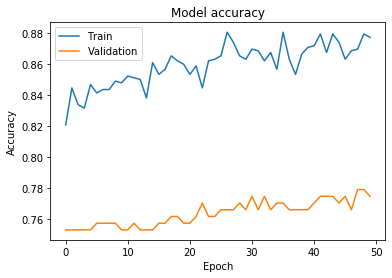

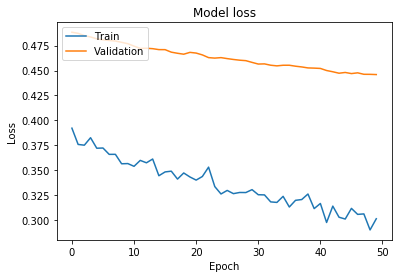

F1 score is:  0.75
Recall score is:  0.75
Precision score is:  0.75
Confusion matrix: 
 [[112  32]
 [ 41 103]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 41 false negatives and 103 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 420ms/step - loss: 0.7320 - acc: 0.5382 - val_loss: 0.7586 - val_acc: 0.5931

Epoch 00001: val_loss improved from inf to 0.75864, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 290ms/step - loss: 0.7113 - acc: 0.5727 - val_loss: 0.7124 - val_acc: 0.6234

Epoch 00002: val_loss improved from 0.75864 to 0.71243, saving mo

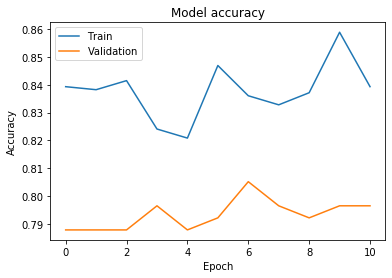

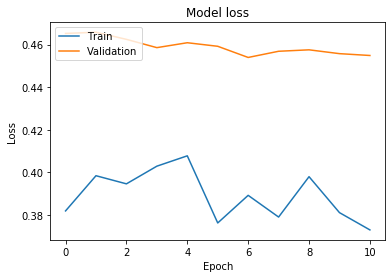

F1 score is:  0.75
Recall score is:  0.77
Precision score is:  0.75
Confusion matrix: 
 [[ 90  54]
 [ 17 127]]
From the confusion matrix above there are 90 true negatives and 54 false positives.
There are 17 false negatives and 127 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 421ms/step - loss: 0.8124 - acc: 0.5288 - val_loss: 1.0211 - val_acc: 0.5152

Epoch 00001: val_loss improved from inf to 1.02108, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.7262 - acc: 0.5735 - val_loss: 0.8844 - val_acc: 0.5281

Epoch 00002: val_loss improved from 1.02108 to 0.88443, saving mod

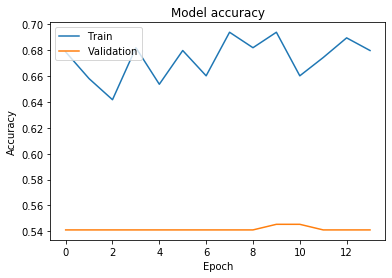

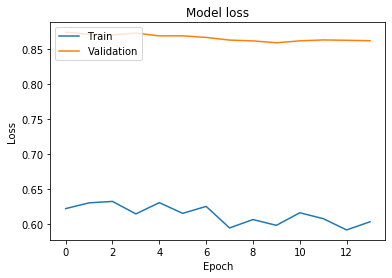

F1 score is:  0.41
Recall score is:  0.65
Precision score is:  0.53
Confusion matrix: 
 [[141   3]
 [133  11]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 133 false negatives and 11 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 857ms/step - loss: 0.6991 - acc: 0.5168 - val_loss: 0.6682 - val_acc: 0.5974

Epoch 00001: val_loss improved from inf to 0.66817, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.6906 - acc: 0.5478 - val_loss: 0.6662 - val_acc: 0.6061

Epoch 00002: val_loss improved from 0.66817 t

Epoch 11/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5678 - acc: 0.7414 - val_loss: 0.5894 - val_acc: 0.6883

Epoch 00011: val_loss improved from 0.59029 to 0.58942, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5723 - acc: 0.7406 - val_loss: 0.5889 - val_acc: 0.6883

Epoch 00012: val_loss improved from 0.58942 to 0.58895, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5685 - acc: 0.7439 - val_loss: 0.5885 - val_acc: 0.6883

Epoch 00013: val_loss improved from 0.58895 to 0.58846, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5743 - acc: 0.7325 - val_loss: 0.5877 - val_acc: 0.6883

Epoch 00014: val_loss improved from 0.58846 to 0.58772, saving model to ./model

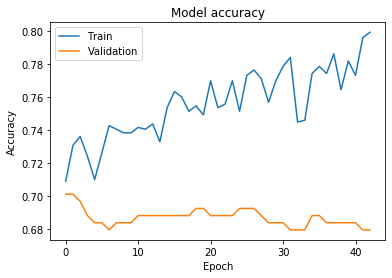

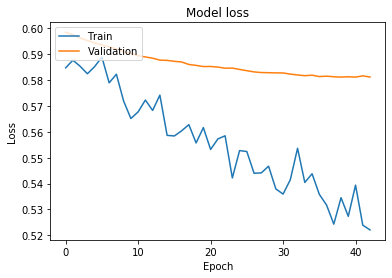

F1 score is:  0.66
Recall score is:  0.69
Precision score is:  0.67
Confusion matrix: 
 [[121  23]
 [ 73  71]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 73 false negatives and 71 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 856ms/step - loss: 0.6976 - acc: 0.5435 - val_loss: 0.7191 - val_acc: 0.5152

Epoch 00001: val_loss improved from inf to 0.71915, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7023 - acc: 0.5336 - val_loss: 0.7177 - val_acc: 0.5152

Epoch 00002: val_loss improved from 0.71915 t


Epoch 00014: val_loss did not improve from 0.68129
Epoch 15/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5654 - acc: 0.7641 - val_loss: 0.6829 - val_acc: 0.5498

Epoch 00015: val_loss did not improve from 0.68129
Epoch 16/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5562 - acc: 0.7551 - val_loss: 0.6832 - val_acc: 0.5498

Epoch 00016: val_loss did not improve from 0.68129
Epoch 17/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5520 - acc: 0.7713 - val_loss: 0.6829 - val_acc: 0.5498

Epoch 00017: val_loss did not improve from 0.68129
Epoch 18/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5649 - acc: 0.7557 - val_loss: 0.6827 - val_acc: 0.5498

Epoch 00018: val_loss did not improve from 0.68129
Epoch 00018: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
EfficientNet B4 FT Dropout: 0.3 : Counter: 3, Accuracies: Validation: 54.11 %, Test: 54.17 %


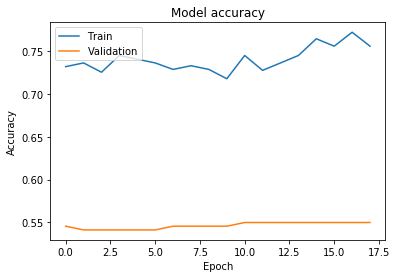

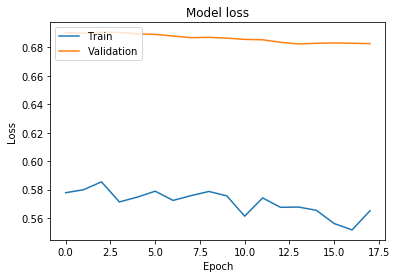

F1 score is:  0.45
Recall score is:  0.63
Precision score is:  0.54
Confusion matrix: 
 [[137   7]
 [125  19]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 125 false negatives and 19 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 877ms/step - loss: 0.7015 - acc: 0.5106 - val_loss: 0.7091 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.70909, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 543ms/step - loss: 0.7034 - acc: 0.5309 - val_loss: 0.7068 - val_acc: 0.4978

Epoch 00002: val_loss improved from 0.70909 t

Epoch 11/50
29/29 [==============================] - 16s 546ms/step - loss: 0.5769 - acc: 0.7271 - val_loss: 0.6195 - val_acc: 0.6883

Epoch 00011: val_loss improved from 0.62056 to 0.61948, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5810 - acc: 0.7205 - val_loss: 0.6185 - val_acc: 0.6840

Epoch 00012: val_loss improved from 0.61948 to 0.61847, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5770 - acc: 0.7304 - val_loss: 0.6176 - val_acc: 0.6883

Epoch 00013: val_loss improved from 0.61847 to 0.61755, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5763 - acc: 0.7271 - val_loss: 0.6164 - val_acc: 0.6883

Epoch 00014: val_loss improved from 0.61755 to 0.61638, saving model to ./model

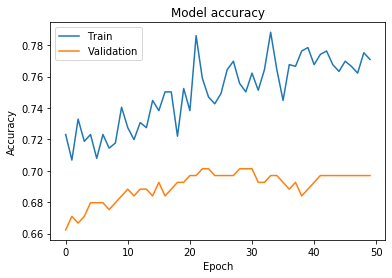

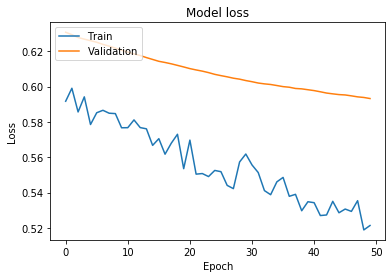

F1 score is:  0.65
Recall score is:  0.68
Precision score is:  0.66
Confusion matrix: 
 [[119  25]
 [ 72  72]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 72 false negatives and 72 true positives. 

Validation score of Ensemble of 1 & 2:  81.39 %
Test score of Ensemble of 1 & 2:  78.47 %
F1 score is:  0.78
Recall score is:  0.79
Precision score is:  0.78
Confusion matrix: 
 [[106  38]
 [ 24 120]]
From the confusion matrix above there are 106 true negatives and 38 false positives.
There are 24 false negatives and 120 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 
3       3                                              72.57                 

  

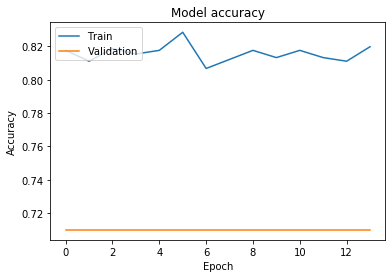

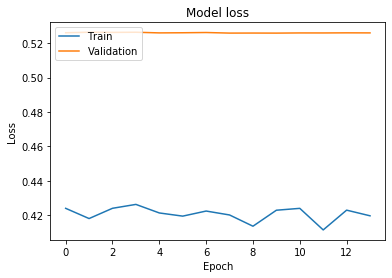

F1 score is:  0.75
Recall score is:  0.79
Precision score is:  0.75
Confusion matrix: 
 [[133  11]
 [ 60  84]]
From the confusion matrix above there are 133 true negatives and 11 false positives.
There are 60 false negatives and 84 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 423ms/step - loss: 0.7140 - acc: 0.5678 - val_loss: 0.6659 - val_acc: 0.5411

Epoch 00001: val_loss improved from inf to 0.66588, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.6872 - acc: 0.5858 - val_loss: 0.6514 - val_acc: 0.5455

Epoch 00002: val_loss improved from 0.66588 to 0.65137, saving mod

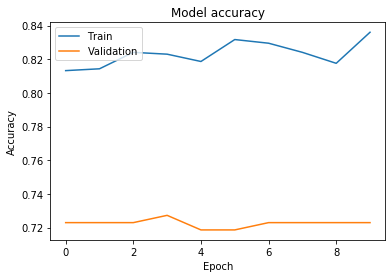

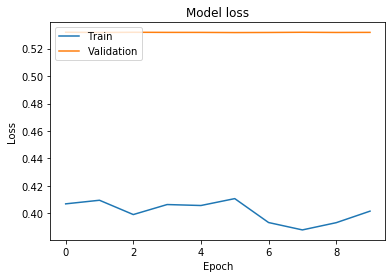

F1 score is:  0.72
Recall score is:  0.74
Precision score is:  0.73
Confusion matrix: 
 [[121  23]
 [ 56  88]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 56 false negatives and 88 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 423ms/step - loss: 0.8091 - acc: 0.5207 - val_loss: 0.6880 - val_acc: 0.5455

Epoch 00001: val_loss improved from inf to 0.68802, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 290ms/step - loss: 0.7378 - acc: 0.5567 - val_loss: 0.6771 - val_acc: 0.5714

Epoch 00002: val_loss improved from 0.68802 to 0.67714, saving mod

Epoch 13/50
29/29 [==============================] - 9s 296ms/step - loss: 0.3846 - acc: 0.8153 - val_loss: 0.4790 - val_acc: 0.7965

Epoch 00013: val_loss improved from 0.47926 to 0.47898, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 9s 297ms/step - loss: 0.3806 - acc: 0.8344 - val_loss: 0.4790 - val_acc: 0.8009

Epoch 00014: val_loss did not improve from 0.47898
Epoch 15/50
29/29 [==============================] - 9s 296ms/step - loss: 0.3717 - acc: 0.8466 - val_loss: 0.4782 - val_acc: 0.8009

Epoch 00015: val_loss improved from 0.47898 to 0.47818, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 16/50
29/29 [==============================] - 9s 296ms/step - loss: 0.3622 - acc: 0.8266 - val_loss: 0.4770 - val_acc: 0.8052

Epoch 00016: val_loss improved from 0.47818 to 0.47701, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 17/50
29/29 [==============================] - 

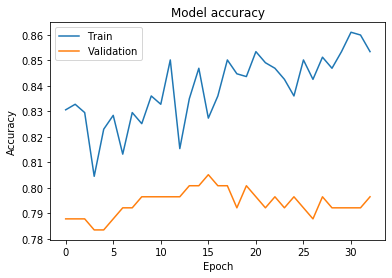

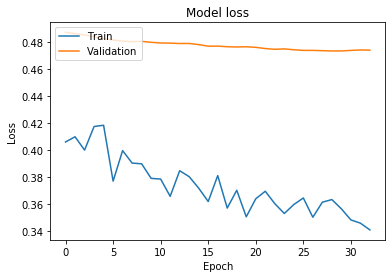

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[118  26]
 [ 33 111]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 33 false negatives and 111 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 859ms/step - loss: 0.7329 - acc: 0.4640 - val_loss: 0.7118 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 0.71179, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 538ms/step - loss: 0.7242 - acc: 0.4711 - val_loss: 0.7091 - val_acc: 0.5108

Epoch 00002: val_loss improved from 0.71179 to 

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5737 - acc: 0.7598 - val_loss: 0.6176 - val_acc: 0.6320

Epoch 00011: val_loss improved from 0.61867 to 0.61758, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5806 - acc: 0.7425 - val_loss: 0.6169 - val_acc: 0.6320

Epoch 00012: val_loss improved from 0.61758 to 0.61685, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5770 - acc: 0.7460 - val_loss: 0.6159 - val_acc: 0.6320

Epoch 00013: val_loss improved from 0.61685 to 0.61591, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5764 - acc: 0.7505 - val_loss: 0.6151 - val_acc: 0.6320

Epoch 00014: val_loss improved from 0.61591 to 0.61514, saving model to ./model

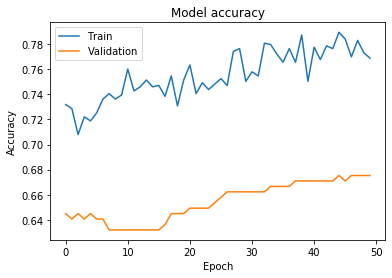

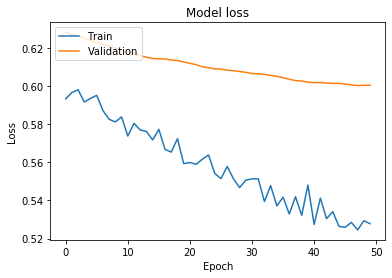

F1 score is:  0.63
Recall score is:  0.68
Precision score is:  0.65
Confusion matrix: 
 [[124  20]
 [ 81  63]]
From the confusion matrix above there are 124 true negatives and 20 false positives.
There are 81 false negatives and 63 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 861ms/step - loss: 0.7029 - acc: 0.5115 - val_loss: 0.7366 - val_acc: 0.4892

Epoch 00001: val_loss improved from inf to 0.73656, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 536ms/step - loss: 0.7037 - acc: 0.5312 - val_loss: 0.7348 - val_acc: 0.4892

Epoch 00002: val_loss improved from 0.73656 t


Epoch 00012: val_loss improved from 0.68254 to 0.68211, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5691 - acc: 0.7552 - val_loss: 0.6824 - val_acc: 0.5498

Epoch 00013: val_loss did not improve from 0.68211
Epoch 14/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5769 - acc: 0.7315 - val_loss: 0.6822 - val_acc: 0.5498

Epoch 00014: val_loss did not improve from 0.68211
Epoch 15/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5627 - acc: 0.7444 - val_loss: 0.6818 - val_acc: 0.5498

Epoch 00015: val_loss improved from 0.68211 to 0.68179, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 16/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5741 - acc: 0.7434 - val_loss: 0.6814 - val_acc: 0.5541

Epoch 00016: val_loss improved from 0.68179 to 0.68140, saving model to ./model/EfficientNet B4 FT Drop

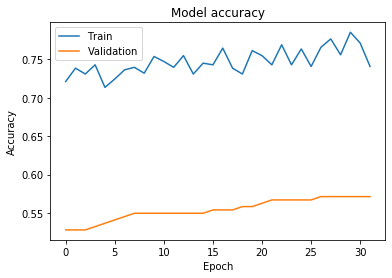

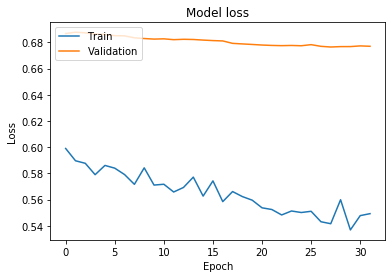

F1 score is:  0.48
Recall score is:  0.75
Precision score is:  0.57
Confusion matrix: 
 [[143   1]
 [123  21]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 123 false negatives and 21 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 859ms/step - loss: 0.7297 - acc: 0.4691 - val_loss: 0.7237 - val_acc: 0.4632

Epoch 00001: val_loss improved from inf to 0.72371, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 541ms/step - loss: 0.7144 - acc: 0.5118 - val_loss: 0.7216 - val_acc: 0.4719

Epoch 00002: val_loss improved from 0.72371 t

Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5803 - acc: 0.7366 - val_loss: 0.6482 - val_acc: 0.6364

Epoch 00012: val_loss improved from 0.64918 to 0.64824, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5914 - acc: 0.7074 - val_loss: 0.6470 - val_acc: 0.6407

Epoch 00013: val_loss improved from 0.64824 to 0.64695, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5704 - acc: 0.7328 - val_loss: 0.6459 - val_acc: 0.6407

Epoch 00014: val_loss improved from 0.64695 to 0.64592, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5748 - acc: 0.7244 - val_loss: 0.6456 - val_acc: 0.6364

Epoch 00015: val_loss improved from 0.64592 to 0.64564, saving model to ./model

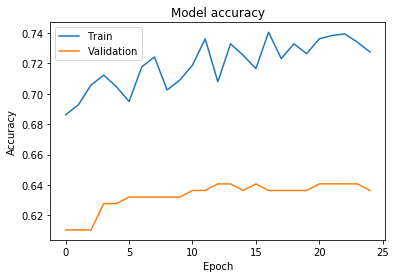

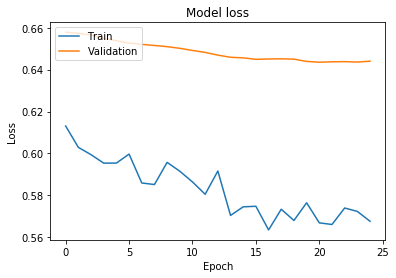

F1 score is:  0.51
Recall score is:  0.63
Precision score is:  0.57
Confusion matrix: 
 [[131  13]
 [111  33]]
From the confusion matrix above there are 131 true negatives and 13 false positives.
There are 111 false negatives and 33 true positives. 

Validation score of Ensemble of 1 & 2:  73.59 %
Test score of Ensemble of 1 & 2:  74.31 %
F1 score is:  0.74
Recall score is:  0.77
Precision score is:  0.74
Confusion matrix: 
 [[128  16]
 [ 58  86]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 58 false negatives and 86 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 
3       3                                              72.57                 
4  

29/29 [==============================] - 8s 291ms/step - loss: 0.4093 - acc: 0.8116 - val_loss: 0.5024 - val_acc: 0.7879

Epoch 00044: val_loss improved from 0.50508 to 0.50241, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 45/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4048 - acc: 0.8116 - val_loss: 0.4998 - val_acc: 0.7879

Epoch 00045: val_loss improved from 0.50241 to 0.49979, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 46/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4154 - acc: 0.8056 - val_loss: 0.5008 - val_acc: 0.7879

Epoch 00046: val_loss did not improve from 0.49979
Epoch 47/50
29/29 [==============================] - 8s 290ms/step - loss: 0.4036 - acc: 0.8156 - val_loss: 0.4968 - val_acc: 0.7922

Epoch 00047: val_loss improved from 0.49979 to 0.49678, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 48/50
29/29 [==============================] - 8s 290ms/ste

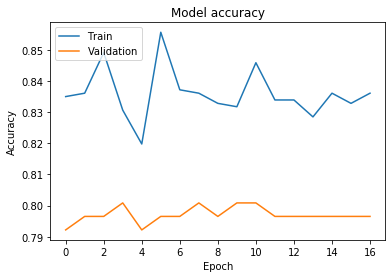

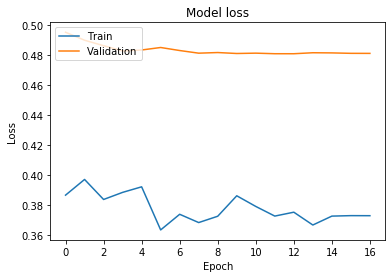

F1 score is:  0.78
Recall score is:  0.78
Precision score is:  0.78
Confusion matrix: 
 [[119  25]
 [ 39 105]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 39 false negatives and 105 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 425ms/step - loss: 0.7817 - acc: 0.4928 - val_loss: 0.8617 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 0.86169, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.7515 - acc: 0.5201 - val_loss: 0.8197 - val_acc: 0.3636

Epoch 00002: val_loss improved from 0.86169 to 0.81970, saving mo


 ResNet50 FT Dropout: 0.3 : Counter: 5, Testing Accuracy: 62.85 % 


 
 ############################################### 
 
 Retraining with last conv layer unfrozen 
 
Epoch 1/50
29/29 [==============================] - 13s 450ms/step - loss: 0.4654 - acc: 0.7703 - val_loss: 0.6076 - val_acc: 0.6494

Epoch 00001: val_loss did not improve from 0.60130
Epoch 2/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4744 - acc: 0.7665 - val_loss: 0.6072 - val_acc: 0.6494

Epoch 00002: val_loss did not improve from 0.60130
Epoch 3/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4564 - acc: 0.7908 - val_loss: 0.6073 - val_acc: 0.6494

Epoch 00003: val_loss did not improve from 0.60130
Epoch 4/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4549 - acc: 0.7965 - val_loss: 0.6074 - val_acc: 0.6494

Epoch 00004: val_loss did not improve from 0.60130
Epoch 5/50
29/29 [==============================] - 9s 298ms/step - loss: 0.4498 - acc: 0.7940

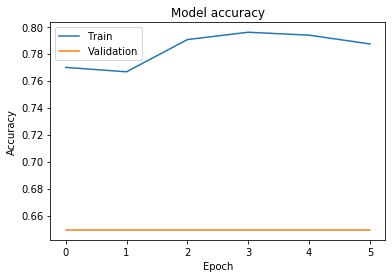

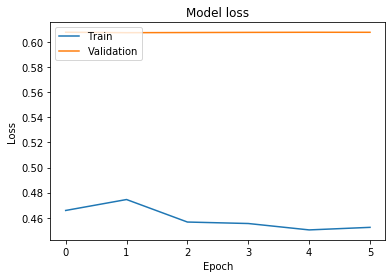

F1 score is:  0.61
Recall score is:  0.67
Precision score is:  0.63
Confusion matrix: 
 [[124  20]
 [ 86  58]]
From the confusion matrix above there are 124 true negatives and 20 false positives.
There are 86 false negatives and 58 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 426ms/step - loss: 0.7956 - acc: 0.5132 - val_loss: 0.9681 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.96813, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 288ms/step - loss: 0.7627 - acc: 0.5516 - val_loss: 0.9169 - val_acc: 0.5065

Epoch 00002: val_loss improved from 0.96813 to 0.91688, saving mod


 ResNet50 FT Dropout: 0.4 : Counter: 5, Testing Accuracy: 59.03 % 


 
 ############################################### 
 
 Retraining with last conv layer unfrozen 
 
Epoch 1/50
29/29 [==============================] - 14s 481ms/step - loss: 0.4616 - acc: 0.7779 - val_loss: 0.7445 - val_acc: 0.5584

Epoch 00001: val_loss improved from 0.75202 to 0.74446, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4401 - acc: 0.8108 - val_loss: 0.7409 - val_acc: 0.5584

Epoch 00002: val_loss improved from 0.74446 to 0.74091, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4503 - acc: 0.7817 - val_loss: 0.7420 - val_acc: 0.5584

Epoch 00003: val_loss did not improve from 0.74091
Epoch 4/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4656 - acc: 0.7806 - val_loss: 0.7399 - val_acc: 0.5584

Epoch 0

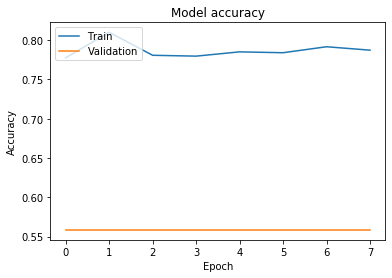

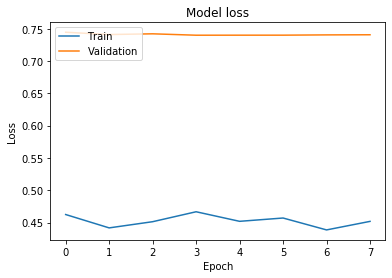

F1 score is:  0.54
Recall score is:  0.77
Precision score is:  0.61
Confusion matrix: 
 [[143   1]
 [112  32]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 112 false negatives and 32 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 863ms/step - loss: 0.7119 - acc: 0.5104 - val_loss: 0.7217 - val_acc: 0.5065

Epoch 00001: val_loss improved from inf to 0.72174, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 541ms/step - loss: 0.7134 - acc: 0.4975 - val_loss: 0.7186 - val_acc: 0.5152

Epoch 00002: val_loss improved from 0.72174 t

Epoch 11/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5848 - acc: 0.7334 - val_loss: 0.6080 - val_acc: 0.6623

Epoch 00011: val_loss improved from 0.60922 to 0.60804, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5736 - acc: 0.7380 - val_loss: 0.6068 - val_acc: 0.6667

Epoch 00012: val_loss improved from 0.60804 to 0.60683, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5710 - acc: 0.7452 - val_loss: 0.6057 - val_acc: 0.6667

Epoch 00013: val_loss improved from 0.60683 to 0.60571, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5676 - acc: 0.7588 - val_loss: 0.6047 - val_acc: 0.6623

Epoch 00014: val_loss improved from 0.60571 to 0.60472, saving model to ./model

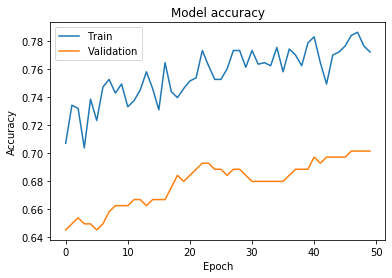

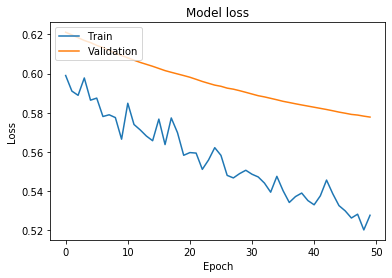

F1 score is:  0.67
Recall score is:  0.68
Precision score is:  0.67
Confusion matrix: 
 [[106  38]
 [ 56  88]]
From the confusion matrix above there are 106 true negatives and 38 false positives.
There are 56 false negatives and 88 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 876ms/step - loss: 0.6939 - acc: 0.5484 - val_loss: 0.6912 - val_acc: 0.5628

Epoch 00001: val_loss improved from inf to 0.69118, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6904 - acc: 0.5482 - val_loss: 0.6888 - val_acc: 0.5628

Epoch 00002: val_loss improved from 0.69118 t

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5800 - acc: 0.7417 - val_loss: 0.5970 - val_acc: 0.6970

Epoch 00011: val_loss improved from 0.59815 to 0.59700, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5700 - acc: 0.7237 - val_loss: 0.5960 - val_acc: 0.6970

Epoch 00012: val_loss improved from 0.59700 to 0.59596, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5740 - acc: 0.7452 - val_loss: 0.5948 - val_acc: 0.6970

Epoch 00013: val_loss improved from 0.59596 to 0.59484, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5584 - acc: 0.7575 - val_loss: 0.5938 - val_acc: 0.6926

Epoch 00014: val_loss improved from 0.59484 to 0.59376, saving model to ./model

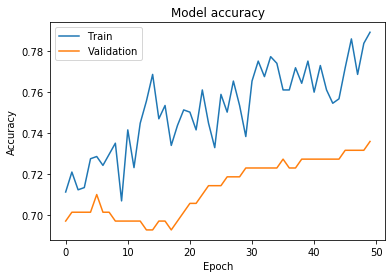

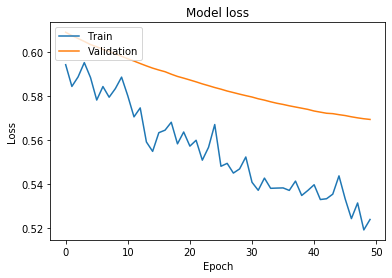

F1 score is:  0.73
Recall score is:  0.73
Precision score is:  0.73
Confusion matrix: 
 [[106  38]
 [ 41 103]]
From the confusion matrix above there are 106 true negatives and 38 false positives.
There are 41 false negatives and 103 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 865ms/step - loss: 0.7197 - acc: 0.4794 - val_loss: 0.7021 - val_acc: 0.5238

Epoch 00001: val_loss improved from inf to 0.70211, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 541ms/step - loss: 0.7265 - acc: 0.4756 - val_loss: 0.6999 - val_acc: 0.5238

Epoch 00002: val_loss improved from 0.70211 

Epoch 11/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5794 - acc: 0.7286 - val_loss: 0.6137 - val_acc: 0.6580

Epoch 00011: val_loss improved from 0.61430 to 0.61371, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5810 - acc: 0.7243 - val_loss: 0.6127 - val_acc: 0.6580

Epoch 00012: val_loss improved from 0.61371 to 0.61269, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5807 - acc: 0.7256 - val_loss: 0.6117 - val_acc: 0.6580

Epoch 00013: val_loss improved from 0.61269 to 0.61169, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5706 - acc: 0.7194 - val_loss: 0.6106 - val_acc: 0.6580

Epoch 00014: val_loss improved from 0.61169 to 0.61060, saving model to ./model

Epoch 43/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5423 - acc: 0.7603 - val_loss: 0.5951 - val_acc: 0.6840

Epoch 00043: val_loss improved from 0.59535 to 0.59510, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 44/50
29/29 [==============================] - 16s 546ms/step - loss: 0.5349 - acc: 0.7674 - val_loss: 0.5946 - val_acc: 0.6753

Epoch 00044: val_loss improved from 0.59510 to 0.59462, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 45/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5311 - acc: 0.7577 - val_loss: 0.5944 - val_acc: 0.6710

Epoch 00045: val_loss improved from 0.59462 to 0.59440, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 46/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5406 - acc: 0.7477 - val_loss: 0.5941 - val_acc: 0.6710

Epoch 00046: val_loss improved from 0.59440 to 0.59413, saving model to ./model

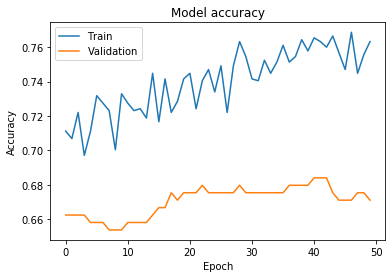

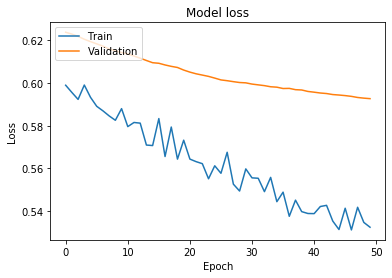

F1 score is:  0.68
Recall score is:  0.7
Precision score is:  0.69
Confusion matrix: 
 [[116  28]
 [ 62  82]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 62 false negatives and 82 true positives. 

Validation score of Ensemble of 1 & 2:  74.03 %
Test score of Ensemble of 1 & 2:  69.79 %
F1 score is:  0.69
Recall score is:  0.73
Precision score is:  0.7
Confusion matrix: 
 [[126  18]
 [ 69  75]]
From the confusion matrix above there are 126 true negatives and 18 false positives.
There are 69 false negatives and 75 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 
3       3                                              72.57                 
4     

Epoch 10/50
29/29 [==============================] - 8s 288ms/step - loss: 0.6252 - acc: 0.6525 - val_loss: 0.7830 - val_acc: 0.5628

Epoch 00010: val_loss did not improve from 0.78160
Epoch 11/50
29/29 [==============================] - 8s 289ms/step - loss: 0.6098 - acc: 0.6597 - val_loss: 0.7783 - val_acc: 0.5801

Epoch 00011: val_loss improved from 0.78160 to 0.77833, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 8s 288ms/step - loss: 0.6049 - acc: 0.6619 - val_loss: 0.7756 - val_acc: 0.5844

Epoch 00012: val_loss improved from 0.77833 to 0.77561, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 8s 290ms/step - loss: 0.5741 - acc: 0.6886 - val_loss: 0.7594 - val_acc: 0.5887

Epoch 00013: val_loss improved from 0.77561 to 0.75939, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 

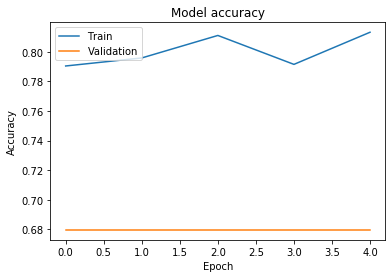

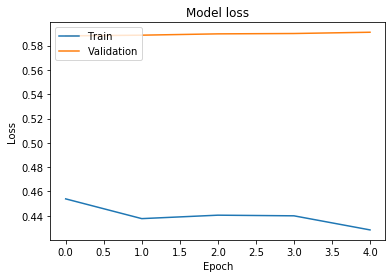

F1 score is:  0.56
Recall score is:  0.67
Precision score is:  0.6
Confusion matrix: 
 [[132  12]
 [103  41]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 103 false negatives and 41 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 423ms/step - loss: 0.7777 - acc: 0.5233 - val_loss: 0.8079 - val_acc: 0.3810

Epoch 00001: val_loss improved from inf to 0.80788, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 287ms/step - loss: 0.7203 - acc: 0.5528 - val_loss: 0.7637 - val_acc: 0.4372

Epoch 00002: val_loss improved from 0.80788 to 0.76370, saving mod

Epoch 16/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4237 - acc: 0.8032 - val_loss: 0.4484 - val_acc: 0.7489

Epoch 00016: val_loss improved from 0.44961 to 0.44845, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 17/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4195 - acc: 0.8224 - val_loss: 0.4485 - val_acc: 0.7532

Epoch 00017: val_loss did not improve from 0.44845
Epoch 18/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4172 - acc: 0.8094 - val_loss: 0.4481 - val_acc: 0.7532

Epoch 00018: val_loss improved from 0.44845 to 0.44807, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 19/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4146 - acc: 0.8185 - val_loss: 0.4480 - val_acc: 0.7532

Epoch 00019: val_loss improved from 0.44807 to 0.44797, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 20/50
29/29 [==============================] - 


Epoch 00050: val_loss improved from 0.43476 to 0.43473, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 FT Dropout: 0.3 : Counter: 6, Accuracies: Validation: 76.19 %, Test: 76.74 %


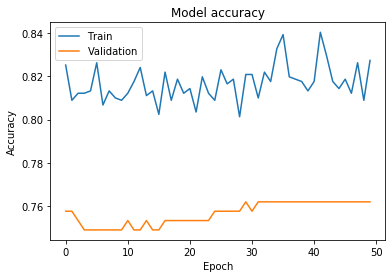

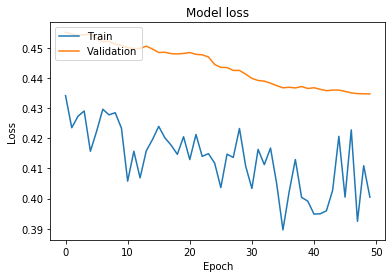

F1 score is:  0.76
Recall score is:  0.78
Precision score is:  0.77
Confusion matrix: 
 [[126  18]
 [ 49  95]]
From the confusion matrix above there are 126 true negatives and 18 false positives.
There are 49 false negatives and 95 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 422ms/step - loss: 0.8098 - acc: 0.5077 - val_loss: 0.8029 - val_acc: 0.4372

Epoch 00001: val_loss improved from inf to 0.80285, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 286ms/step - loss: 0.7558 - acc: 0.5305 - val_loss: 0.7595 - val_acc: 0.5152

Epoch 00002: val_loss improved from 0.80285 to 0.75951, saving mod


Epoch 00032: val_loss did not improve from 0.53689
Epoch 33/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4733 - acc: 0.7922 - val_loss: 0.5291 - val_acc: 0.6797

Epoch 00033: val_loss improved from 0.53689 to 0.52909, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4848 - acc: 0.7692 - val_loss: 0.5302 - val_acc: 0.6797

Epoch 00034: val_loss did not improve from 0.52909
Epoch 35/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4549 - acc: 0.7776 - val_loss: 0.5310 - val_acc: 0.6797

Epoch 00035: val_loss did not improve from 0.52909
Epoch 36/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4437 - acc: 0.7991 - val_loss: 0.5313 - val_acc: 0.6797

Epoch 00036: val_loss did not improve from 0.52909
Epoch 37/50
29/29 [==============================] - 8s 290ms/step - loss: 0.4697 - acc: 0.7631 - val_loss: 0.5294 - val_acc: 0.6797

Epoch

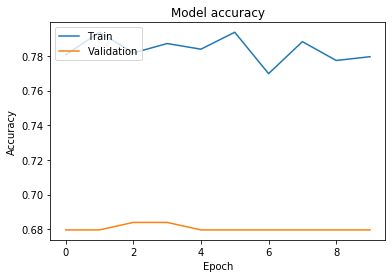

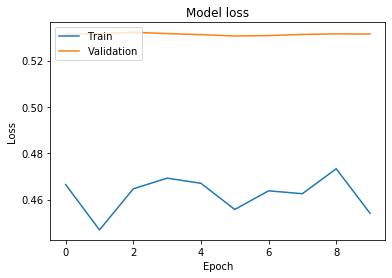

F1 score is:  0.61
Recall score is:  0.66
Precision score is:  0.63
Confusion matrix: 
 [[122  22]
 [ 84  60]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 84 false negatives and 60 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 881ms/step - loss: 0.7201 - acc: 0.4829 - val_loss: 0.7234 - val_acc: 0.4848

Epoch 00001: val_loss improved from inf to 0.72335, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 543ms/step - loss: 0.7248 - acc: 0.4747 - val_loss: 0.7203 - val_acc: 0.4848

Epoch 00002: val_loss improved from 0.72335 t

Epoch 11/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5867 - acc: 0.7110 - val_loss: 0.6078 - val_acc: 0.6623

Epoch 00011: val_loss improved from 0.60894 to 0.60780, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5930 - acc: 0.7131 - val_loss: 0.6067 - val_acc: 0.6623

Epoch 00012: val_loss improved from 0.60780 to 0.60665, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5878 - acc: 0.7159 - val_loss: 0.6052 - val_acc: 0.6623

Epoch 00013: val_loss improved from 0.60665 to 0.60521, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5866 - acc: 0.7178 - val_loss: 0.6036 - val_acc: 0.6623

Epoch 00014: val_loss improved from 0.60521 to 0.60363, saving model to ./model

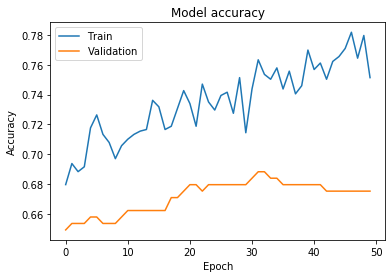

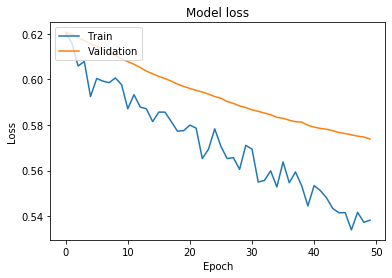

F1 score is:  0.66
Recall score is:  0.71
Precision score is:  0.67
Confusion matrix: 
 [[126  18]
 [ 76  68]]
From the confusion matrix above there are 126 true negatives and 18 false positives.
There are 76 false negatives and 68 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 873ms/step - loss: 0.7208 - acc: 0.4942 - val_loss: 0.6890 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 0.68904, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 539ms/step - loss: 0.7120 - acc: 0.4877 - val_loss: 0.6866 - val_acc: 0.5238

Epoch 00002: val_loss improved from 0.68904 t

Epoch 11/50
29/29 [==============================] - 16s 546ms/step - loss: 0.5812 - acc: 0.7280 - val_loss: 0.5809 - val_acc: 0.7273

Epoch 00011: val_loss improved from 0.58213 to 0.58090, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5820 - acc: 0.7123 - val_loss: 0.5793 - val_acc: 0.7229

Epoch 00012: val_loss improved from 0.58090 to 0.57932, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5791 - acc: 0.7369 - val_loss: 0.5780 - val_acc: 0.7229

Epoch 00013: val_loss improved from 0.57932 to 0.57797, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5885 - acc: 0.7103 - val_loss: 0.5770 - val_acc: 0.7273

Epoch 00014: val_loss improved from 0.57797 to 0.57703, saving model to ./model

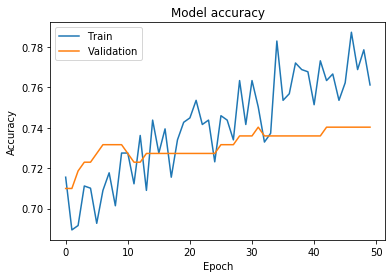

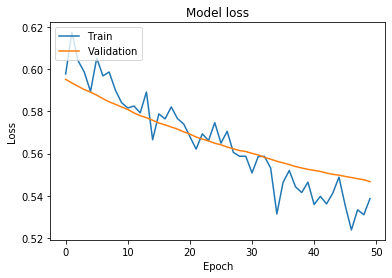

F1 score is:  0.68
Recall score is:  0.7
Precision score is:  0.69
Confusion matrix: 
 [[119  25]
 [ 65  79]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 65 false negatives and 79 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 875ms/step - loss: 0.7071 - acc: 0.5109 - val_loss: 0.6942 - val_acc: 0.5195

Epoch 00001: val_loss improved from inf to 0.69421, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 537ms/step - loss: 0.7090 - acc: 0.5201 - val_loss: 0.6920 - val_acc: 0.5281

Epoch 00002: val_loss improved from 0.69421 to

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5817 - acc: 0.7345 - val_loss: 0.6031 - val_acc: 0.6537

Epoch 00011: val_loss improved from 0.60392 to 0.60310, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5853 - acc: 0.7223 - val_loss: 0.6023 - val_acc: 0.6537

Epoch 00012: val_loss improved from 0.60310 to 0.60234, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5729 - acc: 0.7467 - val_loss: 0.6013 - val_acc: 0.6537

Epoch 00013: val_loss improved from 0.60234 to 0.60127, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5874 - acc: 0.7271 - val_loss: 0.6003 - val_acc: 0.6537

Epoch 00014: val_loss improved from 0.60127 to 0.60028, saving model to ./model

Epoch 43/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5505 - acc: 0.7491 - val_loss: 0.5792 - val_acc: 0.6580

Epoch 00043: val_loss improved from 0.57937 to 0.57916, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 44/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5398 - acc: 0.7722 - val_loss: 0.5786 - val_acc: 0.6580

Epoch 00044: val_loss improved from 0.57916 to 0.57855, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 45/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5360 - acc: 0.7536 - val_loss: 0.5781 - val_acc: 0.6580

Epoch 00045: val_loss improved from 0.57855 to 0.57808, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 46/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5361 - acc: 0.7646 - val_loss: 0.5771 - val_acc: 0.6580

Epoch 00046: val_loss improved from 0.57808 to 0.57709, saving model to ./model

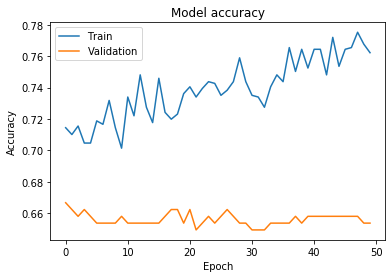

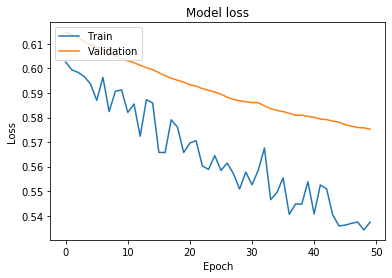

F1 score is:  0.65
Recall score is:  0.69
Precision score is:  0.66
Confusion matrix: 
 [[124  20]
 [ 78  66]]
From the confusion matrix above there are 124 true negatives and 20 false positives.
There are 78 false negatives and 66 true positives. 

Validation score of Ensemble of 1 & 2:  72.73 %
Test score of Ensemble of 1 & 2:  67.01 %
F1 score is:  0.65
Recall score is:  0.71
Precision score is:  0.67
Confusion matrix: 
 [[128  16]
 [ 79  65]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 79 false negatives and 65 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 
3       3                                              72.57                 
4   

Epoch 7/50
29/29 [==============================] - 8s 289ms/step - loss: 0.6239 - acc: 0.6656 - val_loss: 0.6381 - val_acc: 0.6494

Epoch 00007: val_loss improved from 0.64686 to 0.63809, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 8/50
29/29 [==============================] - 8s 289ms/step - loss: 0.6083 - acc: 0.6885 - val_loss: 0.6281 - val_acc: 0.6364

Epoch 00008: val_loss improved from 0.63809 to 0.62810, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 9/50
29/29 [==============================] - 8s 289ms/step - loss: 0.5835 - acc: 0.7069 - val_loss: 0.6171 - val_acc: 0.6494

Epoch 00009: val_loss improved from 0.62810 to 0.61713, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 10/50
29/29 [==============================] - 8s 290ms/step - loss: 0.5797 - acc: 0.7193 - val_loss: 0.6055 - val_acc: 0.6710

Epoch 00010: val_loss improved from 0.61713 to 0.60547, saving model to ./model/ResNet50 FT Dropout: 0.2_be

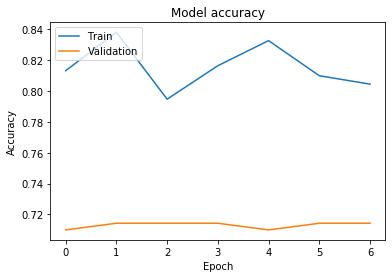

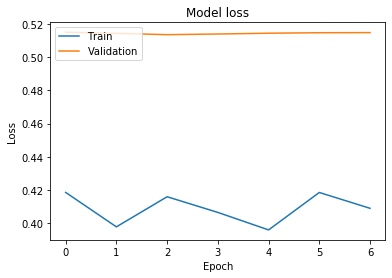

F1 score is:  0.69
Recall score is:  0.69
Precision score is:  0.69
Confusion matrix: 
 [[106  38]
 [ 51  93]]
From the confusion matrix above there are 106 true negatives and 38 false positives.
There are 51 false negatives and 93 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 428ms/step - loss: 0.8616 - acc: 0.4979 - val_loss: 0.8768 - val_acc: 0.4545

Epoch 00001: val_loss improved from inf to 0.87678, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 290ms/step - loss: 0.7459 - acc: 0.4936 - val_loss: 0.7966 - val_acc: 0.4589

Epoch 00002: val_loss improved from 0.87678 to 0.79656, saving mod

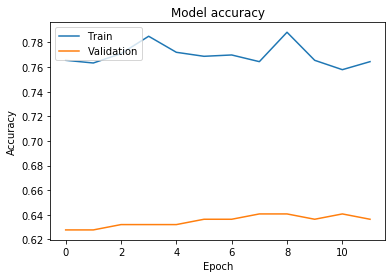

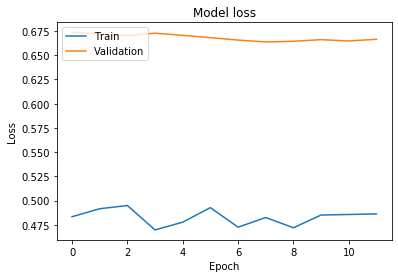

F1 score is:  0.61
Recall score is:  0.7
Precision score is:  0.64
Confusion matrix: 
 [[132  12]
 [ 92  52]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 92 false negatives and 52 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 423ms/step - loss: 0.7938 - acc: 0.4867 - val_loss: 0.7941 - val_acc: 0.5065

Epoch 00001: val_loss improved from inf to 0.79411, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 288ms/step - loss: 0.7712 - acc: 0.5134 - val_loss: 0.7650 - val_acc: 0.5152

Epoch 00002: val_loss improved from 0.79411 to 0.76496, saving mode

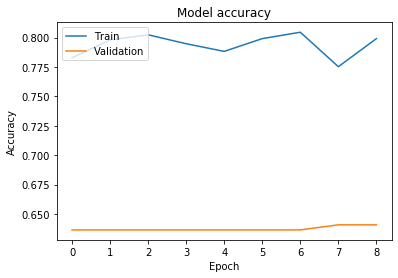

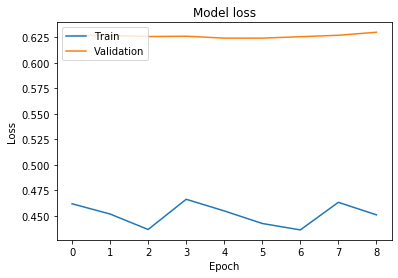

F1 score is:  0.58
Recall score is:  0.67
Precision score is:  0.61
Confusion matrix: 
 [[129  15]
 [ 96  48]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 96 false negatives and 48 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 878ms/step - loss: 0.7060 - acc: 0.4950 - val_loss: 0.7479 - val_acc: 0.3939

Epoch 00001: val_loss improved from inf to 0.74791, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7058 - acc: 0.5142 - val_loss: 0.7460 - val_acc: 0.3939

Epoch 00002: val_loss improved from 0.74791 t

Epoch 11/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5786 - acc: 0.7234 - val_loss: 0.6772 - val_acc: 0.5584

Epoch 00011: val_loss improved from 0.67803 to 0.67725, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5823 - acc: 0.7151 - val_loss: 0.6766 - val_acc: 0.5541

Epoch 00012: val_loss improved from 0.67725 to 0.67664, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5795 - acc: 0.7258 - val_loss: 0.6756 - val_acc: 0.5584

Epoch 00013: val_loss improved from 0.67664 to 0.67563, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5712 - acc: 0.7317 - val_loss: 0.6753 - val_acc: 0.5541

Epoch 00014: val_loss improved from 0.67563 to 0.67527, saving model to ./model

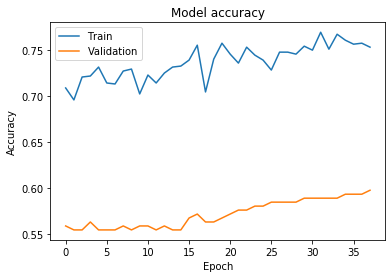

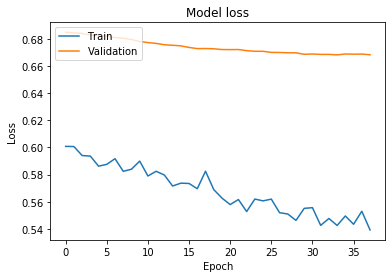

F1 score is:  0.58
Recall score is:  0.64
Precision score is:  0.61
Confusion matrix: 
 [[122  22]
 [ 91  53]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 91 false negatives and 53 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 870ms/step - loss: 0.7048 - acc: 0.5012 - val_loss: 0.6842 - val_acc: 0.5411

Epoch 00001: val_loss improved from inf to 0.68420, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.7074 - acc: 0.5076 - val_loss: 0.6817 - val_acc: 0.5498

Epoch 00002: val_loss improved from 0.68420 t

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5820 - acc: 0.7217 - val_loss: 0.5981 - val_acc: 0.7273

Epoch 00011: val_loss improved from 0.59878 to 0.59811, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5758 - acc: 0.7279 - val_loss: 0.5978 - val_acc: 0.7273

Epoch 00012: val_loss improved from 0.59811 to 0.59779, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5772 - acc: 0.7368 - val_loss: 0.5976 - val_acc: 0.7229

Epoch 00013: val_loss improved from 0.59779 to 0.59759, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5772 - acc: 0.7411 - val_loss: 0.5974 - val_acc: 0.7186

Epoch 00014: val_loss improved from 0.59759 to 0.59743, saving model to ./model

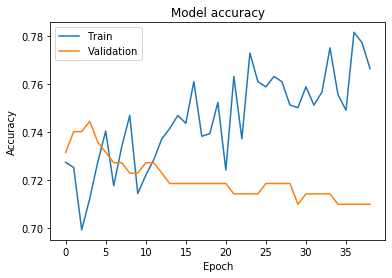

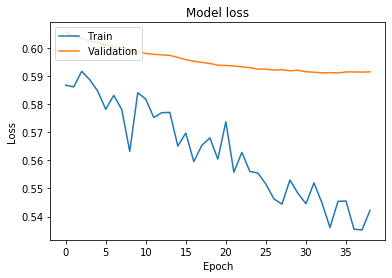

F1 score is:  0.69
Recall score is:  0.71
Precision score is:  0.7
Confusion matrix: 
 [[117  27]
 [ 60  84]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 60 false negatives and 84 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 872ms/step - loss: 0.7064 - acc: 0.5184 - val_loss: 0.7083 - val_acc: 0.4805

Epoch 00001: val_loss improved from inf to 0.70827, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7019 - acc: 0.5291 - val_loss: 0.7065 - val_acc: 0.4935

Epoch 00002: val_loss improved from 0.70827 to


Epoch 00014: val_loss did not improve from 0.66093
Epoch 15/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5729 - acc: 0.7355 - val_loss: 0.6628 - val_acc: 0.5758

Epoch 00015: val_loss did not improve from 0.66093
Epoch 16/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5788 - acc: 0.7371 - val_loss: 0.6625 - val_acc: 0.5758

Epoch 00016: val_loss did not improve from 0.66093
Epoch 17/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5910 - acc: 0.7131 - val_loss: 0.6618 - val_acc: 0.5758

Epoch 00017: val_loss did not improve from 0.66093
Epoch 18/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5773 - acc: 0.7342 - val_loss: 0.6614 - val_acc: 0.5714

Epoch 00018: val_loss did not improve from 0.66093
Epoch 19/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5838 - acc: 0.7134 - val_loss: 0.6613 - val_acc: 0.5714

Epoch 00019: val_loss did not improve from 0.66093
Epoch 20/50
29/29 

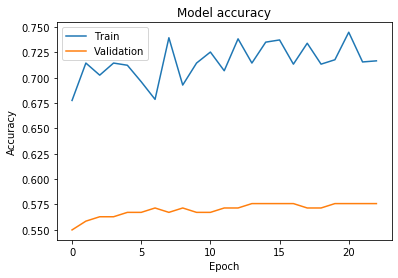

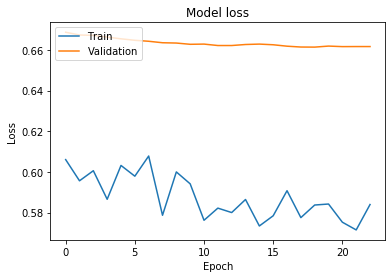

F1 score is:  0.53
Recall score is:  0.63
Precision score is:  0.58
Confusion matrix: 
 [[129  15]
 [107  37]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 107 false negatives and 37 true positives. 

Validation score of Ensemble of 1 & 2:  71.0 %
Test score of Ensemble of 1 & 2:  67.71 %
F1 score is:  0.67
Recall score is:  0.7
Precision score is:  0.68
Confusion matrix: 
 [[123  21]
 [ 72  72]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 72 false negatives and 72 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 
3       3                                              72.57                 
4    

Epoch 4/50
29/29 [==============================] - 8s 288ms/step - loss: 0.6573 - acc: 0.6224 - val_loss: 0.6575 - val_acc: 0.5801

Epoch 00004: val_loss improved from 0.67062 to 0.65751, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 5/50
29/29 [==============================] - 8s 288ms/step - loss: 0.6508 - acc: 0.6291 - val_loss: 0.6449 - val_acc: 0.6061

Epoch 00005: val_loss improved from 0.65751 to 0.64488, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 6/50
29/29 [==============================] - 8s 289ms/step - loss: 0.6072 - acc: 0.6849 - val_loss: 0.6376 - val_acc: 0.6190

Epoch 00006: val_loss improved from 0.64488 to 0.63765, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 7/50
29/29 [==============================] - 8s 288ms/step - loss: 0.6024 - acc: 0.6860 - val_loss: 0.6282 - val_acc: 0.6277

Epoch 00007: val_loss improved from 0.63765 to 0.62820, saving model to ./model/ResNet50 FT Dropout: 0.2_bes

29/29 [==============================] - 9s 298ms/step - loss: 0.4599 - acc: 0.7906 - val_loss: 0.5708 - val_acc: 0.7013

Epoch 00013: val_loss did not improve from 0.56830
Epoch 14/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4614 - acc: 0.7928 - val_loss: 0.5710 - val_acc: 0.7013

Epoch 00014: val_loss did not improve from 0.56830
Epoch 15/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4589 - acc: 0.7925 - val_loss: 0.5709 - val_acc: 0.7013

Epoch 00015: val_loss did not improve from 0.56830
Epoch 16/50
29/29 [==============================] - 9s 297ms/step - loss: 0.4509 - acc: 0.7968 - val_loss: 0.5708 - val_acc: 0.7013

Epoch 00016: val_loss did not improve from 0.56830
Epoch 17/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4703 - acc: 0.7935 - val_loss: 0.5710 - val_acc: 0.7013

Epoch 00017: val_loss did not improve from 0.56830
Epoch 18/50
29/29 [==============================] - 9s 298ms/step - loss: 0.4722 - acc

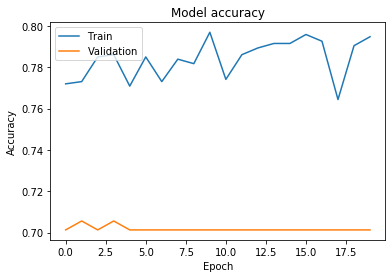

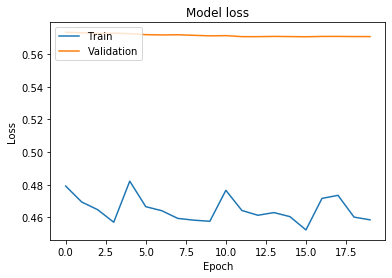

F1 score is:  0.66
Recall score is:  0.69
Precision score is:  0.67
Confusion matrix: 
 [[117  27]
 [ 68  76]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 68 false negatives and 76 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 429ms/step - loss: 0.7742 - acc: 0.5069 - val_loss: 0.7192 - val_acc: 0.4935

Epoch 00001: val_loss improved from inf to 0.71917, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 288ms/step - loss: 0.7270 - acc: 0.5460 - val_loss: 0.7049 - val_acc: 0.5325

Epoch 00002: val_loss improved from 0.71917 to 0.70489, saving mod

Epoch 33/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4405 - acc: 0.7933 - val_loss: 0.5634 - val_acc: 0.7143

Epoch 00033: val_loss did not improve from 0.56249
Epoch 34/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4533 - acc: 0.7931 - val_loss: 0.5678 - val_acc: 0.7100

Epoch 00034: val_loss did not improve from 0.56249
Epoch 35/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4504 - acc: 0.7863 - val_loss: 0.5660 - val_acc: 0.7100

Epoch 00035: val_loss did not improve from 0.56249
Epoch 36/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4312 - acc: 0.8108 - val_loss: 0.5570 - val_acc: 0.7143

Epoch 00036: val_loss improved from 0.56249 to 0.55703, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 37/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4352 - acc: 0.7989 - val_loss: 0.5584 - val_acc: 0.7143

Epoch 00037: val_loss did not improve from 0.55703
Epoch 

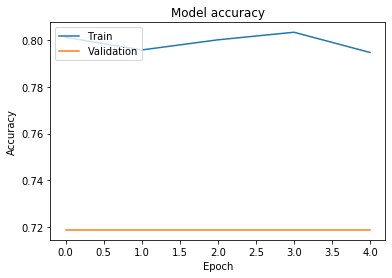

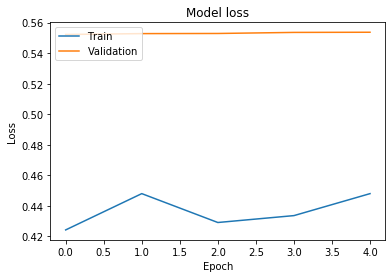

F1 score is:  0.7
Recall score is:  0.71
Precision score is:  0.7
Confusion matrix: 
 [[116  28]
 [ 58  86]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 58 false negatives and 86 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 428ms/step - loss: 0.7181 - acc: 0.5482 - val_loss: 0.7874 - val_acc: 0.5455

Epoch 00001: val_loss improved from inf to 0.78740, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 290ms/step - loss: 0.7141 - acc: 0.5560 - val_loss: 0.7729 - val_acc: 0.5368

Epoch 00002: val_loss improved from 0.78740 to 0.77290, saving model

Epoch 15/50
29/29 [==============================] - 9s 297ms/step - loss: 0.3914 - acc: 0.8216 - val_loss: 0.5020 - val_acc: 0.7792

Epoch 00015: val_loss improved from 0.50353 to 0.50203, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 16/50
29/29 [==============================] - 9s 297ms/step - loss: 0.3821 - acc: 0.8305 - val_loss: 0.5014 - val_acc: 0.7835

Epoch 00016: val_loss improved from 0.50203 to 0.50139, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 17/50
29/29 [==============================] - 9s 298ms/step - loss: 0.3857 - acc: 0.8420 - val_loss: 0.5024 - val_acc: 0.7792

Epoch 00017: val_loss did not improve from 0.50139
Epoch 18/50
29/29 [==============================] - 9s 297ms/step - loss: 0.3705 - acc: 0.8348 - val_loss: 0.5013 - val_acc: 0.7792

Epoch 00018: val_loss improved from 0.50139 to 0.50125, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 19/50
29/29 [==============================] - 

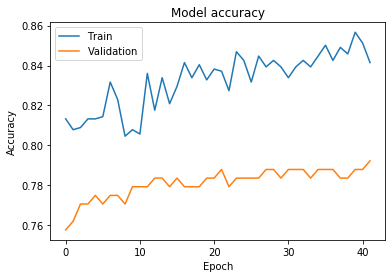

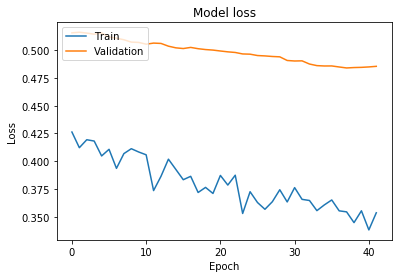

F1 score is:  0.76
Recall score is:  0.77
Precision score is:  0.76
Confusion matrix: 
 [[100  44]
 [ 24 120]]
From the confusion matrix above there are 100 true negatives and 44 false positives.
There are 24 false negatives and 120 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 878ms/step - loss: 0.7084 - acc: 0.5003 - val_loss: 0.7485 - val_acc: 0.4762

Epoch 00001: val_loss improved from inf to 0.74849, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.6989 - acc: 0.5074 - val_loss: 0.7465 - val_acc: 0.4805

Epoch 00002: val_loss improved from 0.74849 

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5895 - acc: 0.7051 - val_loss: 0.6829 - val_acc: 0.5455

Epoch 00011: val_loss improved from 0.68337 to 0.68290, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5804 - acc: 0.7337 - val_loss: 0.6814 - val_acc: 0.5455

Epoch 00012: val_loss improved from 0.68290 to 0.68137, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5725 - acc: 0.7511 - val_loss: 0.6804 - val_acc: 0.5498

Epoch 00013: val_loss improved from 0.68137 to 0.68044, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5764 - acc: 0.7306 - val_loss: 0.6797 - val_acc: 0.5541

Epoch 00014: val_loss improved from 0.68044 to 0.67974, saving model to ./model

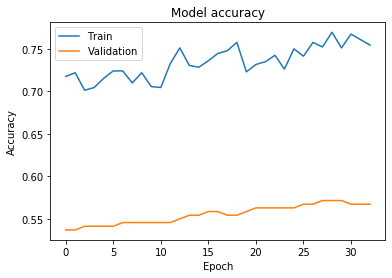

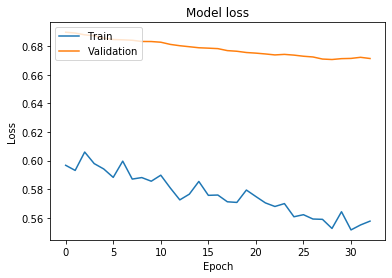

F1 score is:  0.47
Recall score is:  0.67
Precision score is:  0.56
Confusion matrix: 
 [[139   5]
 [123  21]]
From the confusion matrix above there are 139 true negatives and 5 false positives.
There are 123 false negatives and 21 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 871ms/step - loss: 0.7226 - acc: 0.4939 - val_loss: 0.7039 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 0.70386, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.7163 - acc: 0.5044 - val_loss: 0.7016 - val_acc: 0.5195

Epoch 00002: val_loss improved from 0.70386 t

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5953 - acc: 0.6991 - val_loss: 0.6200 - val_acc: 0.6710

Epoch 00011: val_loss improved from 0.62085 to 0.61998, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5810 - acc: 0.7445 - val_loss: 0.6190 - val_acc: 0.6753

Epoch 00012: val_loss improved from 0.61998 to 0.61897, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5864 - acc: 0.7197 - val_loss: 0.6178 - val_acc: 0.6753

Epoch 00013: val_loss improved from 0.61897 to 0.61784, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5758 - acc: 0.7391 - val_loss: 0.6169 - val_acc: 0.6753

Epoch 00014: val_loss improved from 0.61784 to 0.61688, saving model to ./model

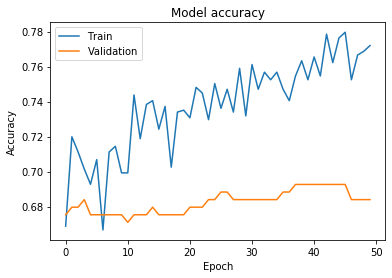

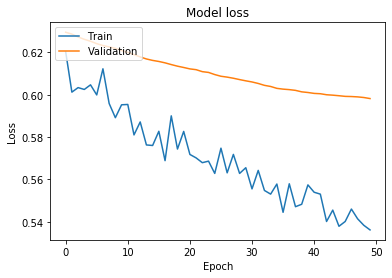

F1 score is:  0.63
Recall score is:  0.66
Precision score is:  0.64
Confusion matrix: 
 [[116  28]
 [ 76  68]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 76 false negatives and 68 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 874ms/step - loss: 0.7179 - acc: 0.4958 - val_loss: 0.7563 - val_acc: 0.4805

Epoch 00001: val_loss improved from inf to 0.75634, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 541ms/step - loss: 0.7132 - acc: 0.5064 - val_loss: 0.7535 - val_acc: 0.4805

Epoch 00002: val_loss improved from 0.75634 t

Epoch 11/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5900 - acc: 0.7100 - val_loss: 0.6448 - val_acc: 0.6190

Epoch 00011: val_loss improved from 0.64628 to 0.64480, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5982 - acc: 0.6962 - val_loss: 0.6433 - val_acc: 0.6147

Epoch 00012: val_loss improved from 0.64480 to 0.64334, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5882 - acc: 0.7318 - val_loss: 0.6420 - val_acc: 0.6190

Epoch 00013: val_loss improved from 0.64334 to 0.64195, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5839 - acc: 0.7272 - val_loss: 0.6407 - val_acc: 0.6277

Epoch 00014: val_loss improved from 0.64195 to 0.64069, saving model to ./model

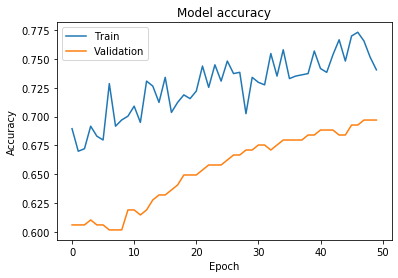

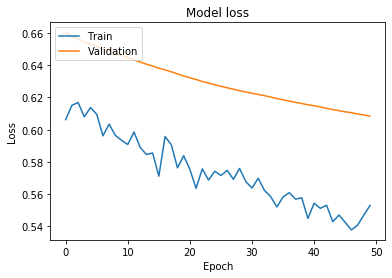

F1 score is:  0.66
Recall score is:  0.67
Precision score is:  0.66
Confusion matrix: 
 [[104  40]
 [ 57  87]]
From the confusion matrix above there are 104 true negatives and 40 false positives.
There are 57 false negatives and 87 true positives. 

Validation score of Ensemble of 1 & 2:  69.7 %
Test score of Ensemble of 1 & 2:  68.75 %
F1 score is:  0.68
Recall score is:  0.7
Precision score is:  0.69
Confusion matrix: 
 [[119  25]
 [ 65  79]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 65 false negatives and 79 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 
3       3                                              72.57                 
4     

Epoch 1/50
29/29 [==============================] - 13s 433ms/step - loss: 0.7533 - acc: 0.5220 - val_loss: 0.7460 - val_acc: 0.5584

Epoch 00001: val_loss improved from inf to 0.74599, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.7249 - acc: 0.5483 - val_loss: 0.7506 - val_acc: 0.5628

Epoch 00002: val_loss did not improve from 0.74599
Epoch 3/50
29/29 [==============================] - 8s 290ms/step - loss: 0.6824 - acc: 0.5855 - val_loss: 0.7350 - val_acc: 0.5931

Epoch 00003: val_loss improved from 0.74599 to 0.73498, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 8s 290ms/step - loss: 0.6645 - acc: 0.6117 - val_loss: 0.7234 - val_acc: 0.6017

Epoch 00004: val_loss improved from 0.73498 to 0.72342, saving model to ./model/ResNet50 FT Dropout: 0.2_bestmodel.hdf5
Epoch 5/50
29/29 [==============================] - 8s 290ms

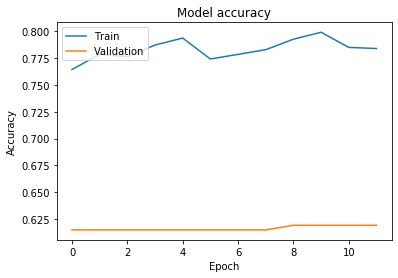

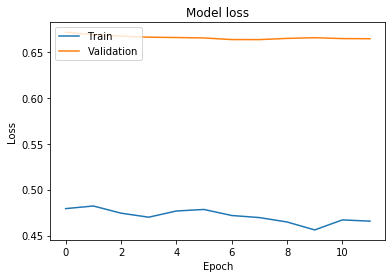

F1 score is:  0.6
Recall score is:  0.67
Precision score is:  0.62
Confusion matrix: 
 [[128  16]
 [ 92  52]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 92 false negatives and 52 true positives. 

ResNet50 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 461ms/step - loss: 0.8098 - acc: 0.4766 - val_loss: 0.7074 - val_acc: 0.5541

Epoch 00001: val_loss improved from inf to 0.70736, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 293ms/step - loss: 0.7527 - acc: 0.5088 - val_loss: 0.6812 - val_acc: 0.5714

Epoch 00002: val_loss improved from 0.70736 to 0.68118, saving mode

29/29 [==============================] - 8s 292ms/step - loss: 0.4505 - acc: 0.7910 - val_loss: 0.5000 - val_acc: 0.7706

Epoch 00032: val_loss did not improve from 0.49405
Epoch 33/50
29/29 [==============================] - 8s 292ms/step - loss: 0.4601 - acc: 0.7910 - val_loss: 0.4936 - val_acc: 0.7619

Epoch 00033: val_loss improved from 0.49405 to 0.49363, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 292ms/step - loss: 0.4563 - acc: 0.7874 - val_loss: 0.4936 - val_acc: 0.7619

Epoch 00034: val_loss improved from 0.49363 to 0.49363, saving model to ./model/ResNet50 FT Dropout: 0.3_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 9s 294ms/step - loss: 0.4496 - acc: 0.8007 - val_loss: 0.4953 - val_acc: 0.7619

Epoch 00035: val_loss did not improve from 0.49363
Epoch 36/50
29/29 [==============================] - 8s 292ms/step - loss: 0.4745 - acc: 0.7716 - val_loss: 0.4972 - val_acc: 0.7706



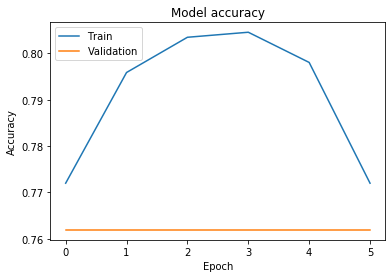

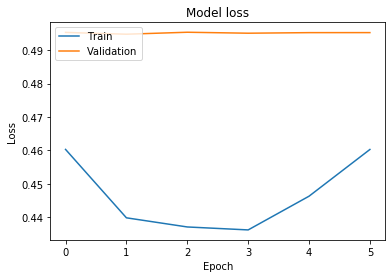

F1 score is:  0.75
Recall score is:  0.76
Precision score is:  0.75
Confusion matrix: 
 [[117  27]
 [ 44 100]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 44 false negatives and 100 true positives. 

ResNet50 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 465ms/step - loss: 0.8172 - acc: 0.4914 - val_loss: 0.6814 - val_acc: 0.5887

Epoch 00001: val_loss improved from inf to 0.68144, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 0.7719 - acc: 0.5184 - val_loss: 0.6567 - val_acc: 0.6147

Epoch 00002: val_loss improved from 0.68144 to 0.65674, saving mo


Epoch 00032: val_loss improved from 0.51745 to 0.51687, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4835 - acc: 0.7724 - val_loss: 0.5190 - val_acc: 0.7532

Epoch 00033: val_loss did not improve from 0.51687
Epoch 34/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4533 - acc: 0.7991 - val_loss: 0.5168 - val_acc: 0.7619

Epoch 00034: val_loss improved from 0.51687 to 0.51675, saving model to ./model/ResNet50 FT Dropout: 0.4_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4661 - acc: 0.7762 - val_loss: 0.5200 - val_acc: 0.7489

Epoch 00035: val_loss did not improve from 0.51675
Epoch 36/50
29/29 [==============================] - 8s 291ms/step - loss: 0.4375 - acc: 0.7915 - val_loss: 0.5219 - val_acc: 0.7446

Epoch 00036: val_loss did not improve from 0.51675
Epoch 37/50
29/29 [==============================] - 8s 291ms/step - l

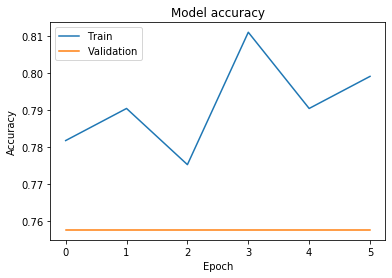

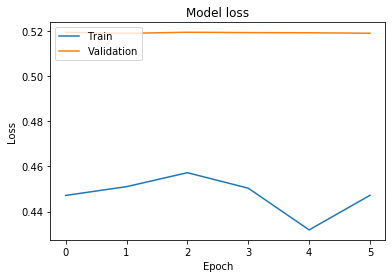

F1 score is:  0.7
Recall score is:  0.72
Precision score is:  0.71
Confusion matrix: 
 [[120  24]
 [ 60  84]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 60 false negatives and 84 true positives. 

EfficientNet B4 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 887ms/step - loss: 0.7083 - acc: 0.4929 - val_loss: 0.7542 - val_acc: 0.5065

Epoch 00001: val_loss improved from inf to 0.75423, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 543ms/step - loss: 0.7010 - acc: 0.5044 - val_loss: 0.7513 - val_acc: 0.5022

Epoch 00002: val_loss improved from 0.75423 to

Epoch 11/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5814 - acc: 0.7299 - val_loss: 0.6341 - val_acc: 0.6494

Epoch 00011: val_loss improved from 0.63577 to 0.63407, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5615 - acc: 0.7767 - val_loss: 0.6324 - val_acc: 0.6580

Epoch 00012: val_loss improved from 0.63407 to 0.63243, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5676 - acc: 0.7541 - val_loss: 0.6310 - val_acc: 0.6623

Epoch 00013: val_loss improved from 0.63243 to 0.63100, saving model to ./model/EfficientNet B4 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5733 - acc: 0.7298 - val_loss: 0.6297 - val_acc: 0.6623

Epoch 00014: val_loss improved from 0.63100 to 0.62970, saving model to ./model

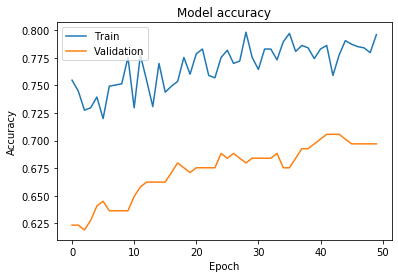

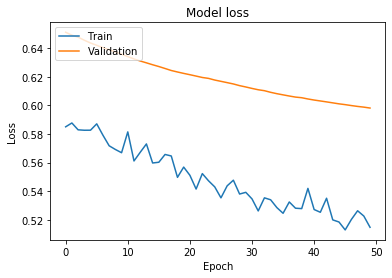

F1 score is:  0.74
Recall score is:  0.74
Precision score is:  0.74
Confusion matrix: 
 [[ 97  47]
 [ 29 115]]
From the confusion matrix above there are 97 true negatives and 47 false positives.
There are 29 false negatives and 115 true positives. 

EfficientNet B4 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 871ms/step - loss: 0.7159 - acc: 0.4821 - val_loss: 0.7212 - val_acc: 0.4892

Epoch 00001: val_loss improved from inf to 0.72122, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7260 - acc: 0.4638 - val_loss: 0.7194 - val_acc: 0.4935

Epoch 00002: val_loss improved from 0.72122 t

Epoch 12/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5776 - acc: 0.7376 - val_loss: 0.6745 - val_acc: 0.5758

Epoch 00012: val_loss improved from 0.67478 to 0.67448, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5696 - acc: 0.7457 - val_loss: 0.6743 - val_acc: 0.5758

Epoch 00013: val_loss improved from 0.67448 to 0.67432, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5742 - acc: 0.7439 - val_loss: 0.6743 - val_acc: 0.5758

Epoch 00014: val_loss improved from 0.67432 to 0.67426, saving model to ./model/EfficientNet B4 FT Dropout: 0.3_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5603 - acc: 0.7557 - val_loss: 0.6743 - val_acc: 0.5758

Epoch 00015: val_loss did not improve from 0.67426
Epoch 16/50
29/29 [=========

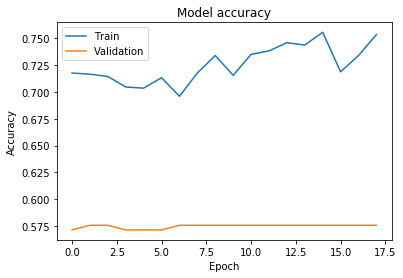

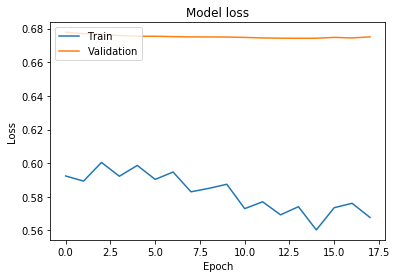

F1 score is:  0.51
Recall score is:  0.72
Precision score is:  0.58
Confusion matrix: 
 [[141   3]
 [117  27]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 117 false negatives and 27 true positives. 

EfficientNet B4 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 878ms/step - loss: 0.7343 - acc: 0.4714 - val_loss: 0.7410 - val_acc: 0.4805

Epoch 00001: val_loss improved from inf to 0.74102, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.7247 - acc: 0.4724 - val_loss: 0.7384 - val_acc: 0.4848

Epoch 00002: val_loss improved from 0.74102 t

Epoch 11/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5682 - acc: 0.7441 - val_loss: 0.6401 - val_acc: 0.6147

Epoch 00011: val_loss improved from 0.64081 to 0.64006, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5844 - acc: 0.7131 - val_loss: 0.6390 - val_acc: 0.6190

Epoch 00012: val_loss improved from 0.64006 to 0.63903, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5828 - acc: 0.7104 - val_loss: 0.6382 - val_acc: 0.6234

Epoch 00013: val_loss improved from 0.63903 to 0.63817, saving model to ./model/EfficientNet B4 FT Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5751 - acc: 0.7352 - val_loss: 0.6374 - val_acc: 0.6234

Epoch 00014: val_loss improved from 0.63817 to 0.63741, saving model to ./model

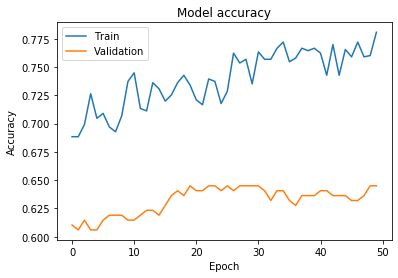

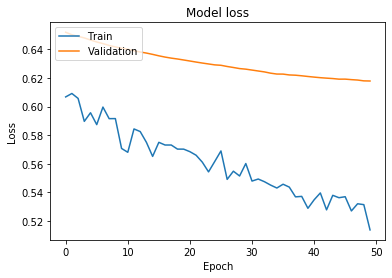

F1 score is:  0.67
Recall score is:  0.68
Precision score is:  0.67
Confusion matrix: 
 [[112  32]
 [ 62  82]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 62 false negatives and 82 true positives. 

Validation score of Ensemble of 1 & 2:  70.13 %
Test score of Ensemble of 1 & 2:  68.75 %
F1 score is:  0.67
Recall score is:  0.73
Precision score is:  0.69
Confusion matrix: 
 [[129  15]
 [ 75  69]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 75 false negatives and 69 true positives. 

results_data 

   Counter  ResNet50 FT Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0       0                                              74.65                 
1       1                                              67.71                 
2       2                                              69.44                 
3       3                                              72.57                 
4   

In [13]:
start = time.time()
print('X, y shapes: ', X.shape, y.shape)

#float32 gives faster speed and negligible loss of precision
X = X.astype('float32')

#Split the data to get a hold out test set
sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
num_splits = sss_initial.get_n_splits(X, y)

for train_val_index, test_index in sss_initial.split(X, y):
    #print('Train-Validation: ', train_val_index, 'Testing', test_index)

    X_train_val = X[train_val_index].copy()
    y_train_val = y[train_val_index].copy()

    X_test = X[test_index].copy()
    y_test = y[test_index].copy()
    
    del X, y
    #Image preprocessing ResNet50
    X_resnet50_band_train_val = resnet.preprocess_input(X_train_val[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_train_val = resnet.preprocess_input(X_train_val[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_train_val processed: max, min', np.max(X_resnet50_band_train_val), np.min(X_resnet50_band_train_val))
    print('X_resnet50_rgb_train_val processed: max, min', np.max(X_resnet50_rgb_train_val), np.min(X_resnet50_rgb_train_val))
    X_resnet50_band_test = resnet.preprocess_input(X_test[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_test = resnet.preprocess_input(X_test[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_test processed: max, min', np.max(X_resnet50_band_test), np.min(X_resnet50_band_test))
    print('X_resnet50_rgb_test processed: max, min', np.max(X_resnet50_rgb_test), np.min(X_resnet50_rgb_test))
    
    X_effnet_band_train_val = X_train_val[:,:,:,0:3].copy()
    X_effnet_rgb_train_val = X_train_val[:,:,:,3:6].copy()
    X_effnet_band_test = X_test[:,:,:,0:3].copy()
    X_effnet_rgb_test = X_test[:,:,:,3:6].copy()
    
    #Image preprocessing EfficientNet B4
    image_size = 224
    
    for i in range(X_train_val.shape[0]):
        X_effnet_band_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_band_train_val[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_train_val[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_band_train_val[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_train_val[i,:,:,:]) #RGB Sentinel image 
    
    for i in range(X_test.shape[0]):
        X_effnet_band_test[i,:,:,:] = center_crop_and_resize(X_effnet_band_test[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_test[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_test[i,:,:,:] = efn.preprocess_input(X_effnet_band_test[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_test[i,:,:,:]) #RGB Sentinel image 
    print('X_effnet_bands_train_val processed: max, min', np.max(X_effnet_band_train_val), np.min(X_effnet_band_train_val))
    print('X_effnet_rgb_train_val processed: max, min', np.max(X_effnet_rgb_train_val), np.min(X_effnet_rgb_train_val))
    print('X_effnet_bands_test processed: max, min', np.max(X_effnet_band_test), np.min(X_effnet_band_test))
    print('X_effnet_rgb_test processed: max, min', np.max(X_effnet_rgb_test), np.min(X_effnet_rgb_test))

    del X_train_val, X_test
    
    results = trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, 
                         X_resnet50_rgb_test, y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, 
                         X_effnet_rgb_train_val, X_effnet_rgb_test)
    
#Save results to CSV
results.to_csv('./model/' + 'FT_Results.csv', sep=',', index=False)

end = time.time()
elapsed = end - start
print('Total running time (s): %i s' % (elapsed))
print('Total running time (min.s): %i min.s' % (elapsed/60.0))
print('Total running time (h): %.2f hours' % (elapsed/3600.0))

## Note
- **The results are contained in the *FT_Results.csv'* file in the *model* folder.**